# 2、单列分析及可视化

这一部分进行单变量分析及可视化

## 2.1 单列分析，整理存储

对于各种数据列，进行单列分析，我们不需要读取所有的东西到内存里面，只需要针对不同的列进行分别处理就好

对于不同的列，会出现不同的取值，我们需要大致知道一个范围
- 如果是类比（比如性别、国家这种有限），就很简单，拿一个dict统计就行，一个个parquet走过去
- 如果是数值（比如income），就显得不那么容易，不过好像也还行，感觉不会出现太离谱的数值，所以可以存一个比较大的dict

字段如下：

| 字段名 | 含义 | 类型 | 特征说明 |
|--------|------|------|---------|
| id | 用户唯一标识 | int64 | 无需处理，可直接使用 |
| last_login | 最近登录时间 | object (ISO时间) | 时间格式需转换 |
| user_name | 用户名 | object | 唯一性可检查，可脱敏 |
| fullname | 用户全名 | object | 可拆分姓与名 |
| email | 电子邮件 | object | 可提取邮箱域名 |
| age | 年龄 | int64 | 可检查异常值与分箱 |
| income | 收入 | float64 | 可标准化或分箱处理 |
| gender | 性别 | object | 类别型，需标准化编码 |
| country | 国家 | object | 类别型，合并小众国家 |
| address | 地址 | object | 可选处理，如地理编码 |
| purchase_history | 购买记录（JSON） | object | 需解析为结构化字段 |
| is_active | 是否活跃 | bool | 可直接使用 |
| registration_date | 注册时间 | object (ISO时间) | 时间格式需转换 |
| phone_number | 电话号码 | object | 可格式标准化，提取国家码 |
| login_history | 登录记录（JSON） | object | 需展开提取如活跃天数、设备等特征 |

其中purchase_history结构如下：
- avg_price, int
- categories, str
- items, list-dict
- payment_method, str
- payment_status, str
- purchase_date, datetime(yyyy-mm-dd)

login_history结构如下：
- avg_session_duration, int
- devices, list-str
- first_login, datetime(yyyy-mm-dd)
- locations, list-str
- login_count, int
- timestamps, list-datetime(yyyy-mm-dd hh-mm-ss)




# **数值字段：分箱统计**

### 1. **`income`（收入）**
- **分箱方式**：按照 **1000为一个bin**，即 `[0-999]`, `[1000-1999]`, ...直到最大值。
- **统计内容**：
  - 每个收过部分归为“>N”。
- **可视化**：
  - 横轴为收入区间，纵轴为人数，使用**柱状图**或**直方图**展示分布。
  - 可增加**累计百分比曲线**，观察收入集中区。

---

### 2. **`purchase_history.avg_price`（平均购买价格）**
- **分箱方式**：按照 **100为一个bin**，即 `[0-99]`, `[100-199]`, ...
- **统计内容**：
  - 每个价格区间的购买记录数量。
- **可视化**：
  - 使用**直方图**显示价格分布。
  - 可叠加不同`categories`的颜色，查看高价商品多集中在哪些类。

---

### 3. **`login_history.login_count`（登录次数）**
- **分箱方式**：按照 **1为一个bin**，即每个登录次数单独统计（如登录1次、2次…）
- **统计内容**：
  - 登录次数对应的用户数量。
- **可视化**：
  - 横轴为登录次数，纵轴为用户数，使用*散柱状图**展示，适用于分析活跃度分层。

---

## **字符串/结构字段：提取与统计**

### 4. **`phone_number`（电话号码）**
- **处理方法**：
  - 提取国家/地区区号（如 `+86`, `+1`, `+44` 等）。
- **统计内容**：
  - 每个区号的用户数量。
- **可视化**：
  - **饼图**或**条形图**展示常见区号。
  - 可添加“其他”区以合并低频区号。

---

### 5. **`email`（邮箱）**
- **处理方法**：
  - 提取域名（如 `gmail.com`, `163.com`, `qq.com`, `hotmail.com`）。
- **统计内容**：
  - 每个邮箱后缀的用量。
- **可视化**：
  - 使用**条形图**展示主流邮箱服务商使用比例。

---

## **时间字段：高分辨率统计**

### 6. **`login_history.timestamps`（登录时间）**
- **分箱方式**：
  - 时间戳先转换为 datetime。
  - 再映射到：**一年 365 天 × 24 小时 = 8760 个小时**，即以小时为分箱单位。
- **统计内容**：
  - 每个小时区间（例如“第123小时”）内的登录次数。
  - 可以转换为 `月-日 时` 格式，用于可视化。
- **可视化**：
  - 使用**热力图（Heatmap）**：
    - 横轴：天（1到365）
    -轴：小时（0到23）
    - 值：该小时该天的登录次数。
  - 可另设一图：**时间序列图**按小时总频次排序。

---


In [1]:
import os
import pandas as pd
import json
import re
from datetime import datetime
from collections import Counter
from collections import defaultdict
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np



In [35]:
class ParquetAnalyzer:
    def __init__(self, folder_path, file_list=None):
        self.folder_path = folder_path
        self.file_list = file_list  # 可选文件列表

        # 初始化所有统计字段的累加器
        self.purchase_category_counter = Counter()
        self.purchase_payment_method_counter = Counter()
        self.purchase_status_counter = Counter()
        self.purchase_date_counter = Counter()

        self.login_device_counter = Counter()
        self.login_location_counter = Counter()
        self.login_first_date_counter = Counter()
        self.login_count_bins = Counter()

        self.income_bins = Counter()
        self.avg_price_bins = Counter()
        self.login_count_bins = Counter()
        self.timestamp_bins = Counter()
        self.phone_code_counter = Counter()
        self.email_domain_counter = Counter()
        self.age_counter = Counter()
        self.gender_counter = Counter()
        self.country_counter = Counter()
        self.address_province_counter = Counter()
        self.non_chinese_address_count = 0

        self.china_provinces = set([
            '北京', '天津', '上海', '重庆',
            '河北', '山西', '辽宁', '吉林', '黑龙江',
            '江苏', '浙江', '安徽', '福建', '江西', '山东',
            '河南', '湖北', '湖南', '广东', '海南',
            '四川', '贵州', '云南', '陕西', '甘肃', '青海',
            '内蒙古', '广西', '西藏', '宁夏', '新疆', '香港', '澳门', '台湾'
        ])

    def _reset_counters(self):
        self.purchase_category_counter.clear()
        self.purchase_payment_method_counter.clear()
        self.purchase_status_counter.clear()
        self.purchase_date_counter.clear()

        self.login_device_counter.clear()
        self.login_location_counter.clear()
        self.login_first_date_counter.clear()
        self.login_count_bins.clear()

        self.income_bins.clear()
        self.avg_price_bins.clear()
        self.timestamp_bins.clear()
        self.phone_code_counter.clear()
        self.email_domain_counter.clear()
        self.age_counter.clear()
        self.gender_counter.clear()
        self.country_counter.clear()
        self.address_province_counter.clear()
        self.non_chinese_address_count = 0
    
    # 处理 purchase_history 字段
    def process_purchase_history(self, df):
        start_time = time.time()
        for val in tqdm(df['purchase_history'], total=df['purchase_history'].shape[0], ncols=80, desc="purchase_history"):
            try:
                record = json.loads(val) if isinstance(val, str) else val
                # 平均价格（每 100 一档）
                price = record.get('avg_price')
                if price is not None:
                    self.avg_price_bins[int(price) // 100] += 1
                    
                # 类别
                categories = record.get("categories")
                if categories:
                    self.purchase_category_counter[categories] += 1

                # 支付方式
                method = record.get("payment_method")
                if method:
                    self.purchase_payment_method_counter[method] += 1

                # 支付状态
                status = record.get("payment_status")
                if status:
                    self.purchase_status_counter[status] += 1

                # 日期
                date = record.get("purchase_date")
                if date:
                    self.purchase_date_counter[date] += 1
            except Exception:
                continue
        end_time = time.time()
        print(f"process_purchase_history耗时: {end_time - start_time:.2f}秒")

    # 处理 login_history 字段
    def process_login_history(self, df):
        start_time = time.time()

        for val in tqdm(df['login_history'], total=df['login_history'].shape[0], ncols=80, desc="login_history"):
            try:
                record = json.loads(val) if isinstance(val, str) else val

                # login_count 分箱（每 1 一档）
                count = record.get('login_count')

                # timestamps 按 day-of-year + hour 分箱
                timestamps = record.get('timestamps', [])
                for ts in timestamps:
                    dt = datetime.strptime(ts, "%Y-%m-%d %H:%M:%S")
                    key = (dt.timetuple().tm_yday, dt.hour)
                    self.timestamp_bins[key] += 1

                # 设备
                devices = record.get("devices", [])
                if isinstance(devices, list):
                    self.login_device_counter.update(devices)
                elif isinstance(devices, str):
                    self.login_device_counter[devices] += 1

                # 登录位置
                locations = record.get("locations", [])
                if isinstance(locations, list):
                    self.login_location_counter.update(locations)
                elif isinstance(locations, str):
                    self.login_location_counter[locations] += 1

                # 首次登录
                first = record.get("first_login")
                if first:
                    self.login_first_date_counter[first] += 1

                # 登录次数
                login_count = record.get("login_count")
                if login_count is not None:
                    self.login_count_bins[login_count] += 1
            except Exception:
                continue
        end_time = time.time()
        print(f"process_login_history耗时: {end_time - start_time:.2f}秒")

    # 额外的字段分析
    def process_additional_fields(self, df):
        start_time = time.time()
        # -------- income 分箱（每 1000 一档） --------
        income_series = df['income'].astype(float)
        self.income_bins.update((income_series // 1000).astype(int))

        # -------- phone_number 区号提取 --------
        for phone in df['phone_number'].astype(str):
            match = re.findall(r'\+\d+', phone)
            if match:
                self.phone_code_counter[match[0]] += 1

        # -------- email 域名提取 --------
        for email in df['email'].astype(str):
            if '@' in email:
                domain = email.split('@')[-1]
                self.email_domain_counter[domain] += 1

        # -------- 年龄频次统计 --------
        self.age_counter.update(df['age'].astype(int))

        # -------- 性别统计（全类别保留） --------
        self.gender_counter.update(df['gender'].astype(str))

        # -------- 国家统计 --------
        self.country_counter.update(df['country'].astype(str))

        # -------- 地址统计（中国省份 + 非中国地址） --------
        for address in df['address'].astype(str):
            matched = False
            for province in self.china_provinces:
                if province in address:
                    self.address_province_counter[province] += 1
                    matched = True
                    break
            if not matched:
                self.address_province_counter['其他'] += 1
        end_time = time.time()
        print(f"process_addtional_fields耗时: {end_time - start_time:.2f}秒")

    # 逐个处理多个parquet文件，并记录分析时间
    def analyze_parquet_files(self):
        files_to_analyze = (
            self.file_list if self.file_list else 
            [f for f in os.listdir(self.folder_path) if f.endswith(".parquet")]
        )
        # 读取文件夹下的所有parquet文件
        total_start_time = time.time()  # 总分析时间统计
        for file in files_to_analyze:
            self._reset_counters()
            start_time = time.time()  # 文件分析开始时间
            print(f"正在分析: {file}")
            path = os.path.join(self.folder_path, file)
            df = pd.read_parquet(path, engine='pyarrow')
            self.process_purchase_history(df)
            self.process_login_history(df)
            self.process_additional_fields(df)
            # 将统计结果导出为CSV
            self.export_all_to_csv(file)
            end_time = time.time()  # 文件分析结束时间
            file_duration = end_time - start_time
            print(f"文件 {file} 分析时间: {file_duration:.2f} 秒")

        total_end_time = time.time()  # 总分析结束时间
        total_duration = total_end_time - total_start_time
        print(f"所有文件总分析时间: {total_duration:.2f} 秒")
        
    # 将结果导出为CSV
    def export_all_to_csv(self, file_name):
        start_time = time.time()
        prefix = os.path.splitext(file_name)[0]
        output_path = os.path.join(self.folder_path, f"{prefix}")
        os.makedirs(output_path, exist_ok=True)
        
        print(f"开始把结果保存为csv：{output_path}")

        # 导出统计结果
        self._export_to_csv(self.purchase_category_counter, output_path, "purchase_category_stats.csv")
        self._export_to_csv(self.purchase_payment_method_counter, output_path, "purchase_payment_method_stats.csv")
        self._export_to_csv(self.purchase_status_counter, output_path, "purchase_status_stats.csv")
        self._export_to_csv(self.purchase_date_counter, output_path, "purchase_date_stats.csv")
        self._export_to_csv(self.avg_price_bins, output_path, "avg_price_bins.csv")

        self._export_to_csv(self.login_device_counter, output_path, "login_device_stats.csv")
        self._export_to_csv(self.login_location_counter, output_path, "login_location_stats.csv")
        self._export_to_csv(self.login_first_date_counter, output_path, "login_first_date_stats.csv")
        self._export_to_csv(self.login_count_bins, output_path, "login_count_stats.csv")
        self._export_to_csv(self.timestamp_bins, output_path, "timestamp_bins.csv")

        self._export_to_csv(self.income_bins, output_path, "income_bins.csv")
        self._export_to_csv(self.phone_code_counter, output_path, "phone_code_bins.csv")
        self._export_to_csv(self.email_domain_counter, output_path, "email_domain_bins.csv")
        self._export_to_csv(self.age_counter, output_path, "age_bins.csv")
        self._export_to_csv(self.gender_counter, output_path, "gender_bins.csv")
        self._export_to_csv(self.address_province_counter, output_path, "address_province_bins.csv")
        self._export_to_csv(self.country_counter, output_path, "country_bins.csv")


        end_time = time.time()
        print(f"全部保存完毕，用时{(end_time-start_time):.2f}s")

    # 导出辅助方法
    def _export_to_csv(self, counter, output_path, filename):
        df = pd.DataFrame(counter.items(), columns=["key", "count"]).sort_values("count", ascending=False)
        df.to_csv(os.path.join(output_path, filename), index=False)


In [9]:
# 分析10G_data_new
analyzer = ParquetAnalyzer('10G_data_new')
analyzer.analyze_parquet_files()


正在分析: part-00002.parquet


purchase_history: 100%|████████████| 5625000/5625000 [01:06<00:00, 84243.59it/s]


process_purchase_history耗时: 66.79秒


login_history: 100%|████████████████| 5625000/5625000 [23:26<00:00, 3999.46it/s]


process_login_history耗时: 1406.44秒
process_addtional_fields耗时: 44.91秒
文件 part-00002.parquet 分析时间: 1553.84 秒
正在分析: part-00006.parquet


purchase_history: 100%|████████████| 5625000/5625000 [01:05<00:00, 85724.86it/s]


process_purchase_history耗时: 65.63秒


login_history:  16%|██▋              | 873511/5625000 [03:32<19:15, 4110.60it/s]


KeyboardInterrupt: 

很明显可以看出，login_history是最费时间的，因为那里面的timestamp指不定有多长，然后我选择了逐一统计高频登录时间段hhh

这个里面呢在运行过程中看到预计剩余时间一直在不断乱跳，跳跃的上下波动大概在4min，说明确实不同的长度而且差的很多

一个文件要1+25+2大概30min，那么8个文件大概推测需要4h

呃这个在jupyter notebook这种随时可能会down的情况下，感觉还是有点心惊胆战，感觉随时就爆了白跑了

考虑30G的东西用tmux跑正常的python代码了

========这是一个分隔符

诶，我现在突然又有个想法，为了防止读取太慢然后裂开，现在希望在传参的时候实现一个比如传文件夹然后整体分析，或者传文件列表只分析某个/某几个文件，然后对每个parquet文件保存所有信息到对应csv，最后再另外写一个代码汇总就好


In [8]:
# 分析10G_data_new，试着跑其中2个
file_list = ["part-00000-1000.parquet"]
analyzer = ParquetAnalyzer("10G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00000-1000.parquet


purchase_history: 100%|██████████████████| 1000/1000 [00:00<00:00, 36071.35it/s]


process_purchase_history耗时: 0.03秒


login_history: 100%|██████████████████████| 1000/1000 [00:00<00:00, 3584.29it/s]


process_login_history耗时: 0.29秒
process_addtional_fields耗时: 0.01秒
开始把结果保存为csv：10G_data_new/part-00000-1000
全部保存完毕，用时0.03s
文件 part-00000-1000.parquet 分析时间: 0.37 秒
所有文件总分析时间: 0.37 秒


wow，作用来了，临时保存的一个小文件，方便我疯狂调试，要不是kernel down掉了，这里的数字不可能是一位数

In [9]:
# 分析10G_data_new，试着跑其中1个
file_list = ["part-00000.parquet"]
analyzer = ParquetAnalyzer("10G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00000.parquet


purchase_history: 100%|████████████| 5625000/5625000 [01:03<00:00, 88128.08it/s]


process_purchase_history耗时: 63.83秒


login_history: 100%|████████████████| 5625000/5625000 [20:14<00:00, 4632.24it/s]


process_login_history耗时: 1214.32秒
process_addtional_fields耗时: 35.77秒
开始把结果保存为csv：10G_data_new/part-00000
全部保存完毕，用时0.06s
文件 part-00000.parquet 分析时间: 1342.25 秒
所有文件总分析时间: 1342.25 秒


In [10]:
# 分析10G_data_new，试着跑其中1个
file_list = ["part-00001.parquet"]
analyzer = ParquetAnalyzer("10G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00001.parquet


purchase_history: 100%|████████████| 5625000/5625000 [00:57<00:00, 97457.68it/s]


process_purchase_history耗时: 57.74秒


login_history: 100%|████████████████| 5625000/5625000 [21:11<00:00, 4423.61it/s]


process_login_history耗时: 1271.59秒
process_addtional_fields耗时: 34.87秒
开始把结果保存为csv：10G_data_new/part-00001
全部保存完毕，用时0.06s
文件 part-00001.parquet 分析时间: 1396.34 秒
所有文件总分析时间: 1396.34 秒


In [11]:
# 分析10G_data_new，试着跑其中1个
file_list = ["part-00002.parquet"]
analyzer = ParquetAnalyzer("10G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00002.parquet


purchase_history: 100%|████████████| 5625000/5625000 [01:04<00:00, 87367.51it/s]


process_purchase_history耗时: 64.45秒


login_history: 100%|████████████████| 5625000/5625000 [21:06<00:00, 4440.55it/s]


process_login_history耗时: 1266.74秒
process_addtional_fields耗时: 47.90秒
开始把结果保存为csv：10G_data_new/part-00002
全部保存完毕，用时0.07s
文件 part-00002.parquet 分析时间: 1411.64 秒
所有文件总分析时间: 1411.64 秒


In [12]:
# 分析10G_data_new，试着跑其中1个
file_list = ["part-00003.parquet"]
analyzer = ParquetAnalyzer("10G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00003.parquet


purchase_history: 100%|████████████| 5625000/5625000 [01:03<00:00, 88495.53it/s]


process_purchase_history耗时: 63.57秒


login_history: 100%|████████████████| 5625000/5625000 [21:57<00:00, 4270.93it/s]


process_login_history耗时: 1317.05秒
process_addtional_fields耗时: 37.09秒
开始把结果保存为csv：10G_data_new/part-00003
全部保存完毕，用时0.07s
文件 part-00003.parquet 分析时间: 1454.70 秒
所有文件总分析时间: 1454.70 秒


In [13]:
# 分析10G_data_new，试着跑其中1个
file_list = ["part-00004.parquet"]
analyzer = ParquetAnalyzer("10G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00004.parquet


purchase_history: 100%|████████████| 5625000/5625000 [01:00<00:00, 93452.83it/s]


process_purchase_history耗时: 60.26秒


login_history: 100%|████████████████| 5625000/5625000 [21:36<00:00, 4340.03it/s]


process_login_history耗时: 1296.08秒
process_addtional_fields耗时: 38.16秒
开始把结果保存为csv：10G_data_new/part-00004
全部保存完毕，用时0.07s
文件 part-00004.parquet 分析时间: 1429.23 秒
所有文件总分析时间: 1429.23 秒


In [14]:
# 分析10G_data_new，试着跑其中1个
file_list = ["part-00005.parquet"]
analyzer = ParquetAnalyzer("10G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00005.parquet


purchase_history: 100%|████████████| 5625000/5625000 [00:59<00:00, 93984.46it/s]


process_purchase_history耗时: 59.86秒


login_history: 100%|████████████████| 5625000/5625000 [21:22<00:00, 4385.56it/s]


process_login_history耗时: 1282.62秒
process_addtional_fields耗时: 38.72秒
开始把结果保存为csv：10G_data_new/part-00005
全部保存完毕，用时0.06s
文件 part-00005.parquet 分析时间: 1416.20 秒
所有文件总分析时间: 1416.20 秒


In [15]:
# 分析10G_data_new，试着跑其中1个
file_list = ["part-00006.parquet"]
analyzer = ParquetAnalyzer("10G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00006.parquet


purchase_history: 100%|████████████| 5625000/5625000 [01:02<00:00, 90028.91it/s]


process_purchase_history耗时: 62.49秒


login_history: 100%|████████████████| 5625000/5625000 [22:52<00:00, 4098.72it/s]


process_login_history耗时: 1372.38秒
process_addtional_fields耗时: 43.76秒
开始把结果保存为csv：10G_data_new/part-00006
全部保存完毕，用时0.07s
文件 part-00006.parquet 分析时间: 1511.13 秒
所有文件总分析时间: 1511.13 秒


In [16]:
# 分析10G_data_new，试着跑其中1个
file_list = ["part-00007.parquet"]
analyzer = ParquetAnalyzer("10G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00007.parquet


purchase_history: 100%|████████████| 5625000/5625000 [00:59<00:00, 93784.39it/s]


process_purchase_history耗时: 59.99秒


login_history: 100%|████████████████| 5625000/5625000 [22:40<00:00, 4135.98it/s]


process_login_history耗时: 1360.02秒
process_addtional_fields耗时: 41.19秒
开始把结果保存为csv：10G_data_new/part-00007
全部保存完毕，用时0.05s
文件 part-00007.parquet 分析时间: 1496.87 秒
所有文件总分析时间: 1496.87 秒


10G分析完毕，分析30G

In [17]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00000.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00000.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:33<00:00, 90307.90it/s]


process_purchase_history耗时: 93.47秒


login_history: 100%|████████████████| 8437500/8437500 [33:05<00:00, 4249.77it/s]


process_login_history耗时: 1985.40秒
process_addtional_fields耗时: 54.03秒
开始把结果保存为csv：30G_data_new/part-00000
全部保存完毕，用时0.07s
文件 part-00000.parquet 分析时间: 2185.72 秒
所有文件总分析时间: 2185.72 秒


In [18]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00001.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00001.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:24<00:00, 99777.93it/s]


process_purchase_history耗时: 84.60秒


login_history: 100%|████████████████| 8437500/8437500 [34:23<00:00, 4089.91it/s]


process_login_history耗时: 2063.01秒
process_addtional_fields耗时: 67.16秒
开始把结果保存为csv：30G_data_new/part-00001
全部保存完毕，用时0.06s
文件 part-00001.parquet 分析时间: 2267.63 秒
所有文件总分析时间: 2267.63 秒


In [19]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00002.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00002.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:40<00:00, 83846.39it/s]


process_purchase_history耗时: 100.67秒


login_history: 100%|████████████████| 8437500/8437500 [34:04<00:00, 4126.82it/s]


process_login_history耗时: 2044.55秒
process_addtional_fields耗时: 63.36秒
开始把结果保存为csv：30G_data_new/part-00002
全部保存完毕，用时0.07s
文件 part-00002.parquet 分析时间: 2263.24 秒
所有文件总分析时间: 2263.24 秒


In [20]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00003.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00003.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:35<00:00, 88177.59it/s]


process_purchase_history耗时: 95.73秒


login_history: 100%|████████████████| 8437500/8437500 [34:12<00:00, 4111.34it/s]


process_login_history耗时: 2052.25秒
process_addtional_fields耗时: 65.22秒
开始把结果保存为csv：30G_data_new/part-00003
全部保存完毕，用时0.07s
文件 part-00003.parquet 分析时间: 2267.58 秒
所有文件总分析时间: 2267.58 秒


In [21]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00004.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00004.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:32<00:00, 91074.09it/s]


process_purchase_history耗时: 92.68秒


login_history: 100%|████████████████| 8437500/8437500 [32:16<00:00, 4356.17it/s]


process_login_history耗时: 1936.91秒
process_addtional_fields耗时: 56.94秒
开始把结果保存为csv：30G_data_new/part-00004
全部保存完毕，用时0.07s
文件 part-00004.parquet 分析时间: 2141.45 秒
所有文件总分析时间: 2141.45 秒


In [22]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00005.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00005.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:31<00:00, 92444.91it/s]


process_purchase_history耗时: 91.31秒


login_history: 100%|████████████████| 8437500/8437500 [32:11<00:00, 4368.67it/s]


process_login_history耗时: 1931.37秒
process_addtional_fields耗时: 57.91秒
开始把结果保存为csv：30G_data_new/part-00005
全部保存完毕，用时0.05s
文件 part-00005.parquet 分析时间: 2133.80 秒
所有文件总分析时间: 2133.80 秒


In [23]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00006.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00006.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:29<00:00, 94700.87it/s]


process_purchase_history耗时: 89.14秒


login_history: 100%|████████████████| 8437500/8437500 [31:45<00:00, 4428.12it/s]


process_login_history耗时: 1905.44秒
process_addtional_fields耗时: 61.07秒
开始把结果保存为csv：30G_data_new/part-00006
全部保存完毕，用时0.06s
文件 part-00006.parquet 分析时间: 2106.93 秒
所有文件总分析时间: 2106.93 秒


In [24]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00007.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00007.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:30<00:00, 93411.44it/s]


process_purchase_history耗时: 90.33秒


login_history: 100%|████████████████| 8437500/8437500 [32:18<00:00, 4351.70it/s]


process_login_history耗时: 1938.90秒
process_addtional_fields耗时: 62.50秒
开始把结果保存为csv：30G_data_new/part-00007
全部保存完毕，用时0.05s
文件 part-00007.parquet 分析时间: 2142.61 秒
所有文件总分析时间: 2142.61 秒


In [25]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00008.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00008.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:33<00:00, 90356.92it/s]


process_purchase_history耗时: 93.42秒


login_history: 100%|████████████████| 8437500/8437500 [32:36<00:00, 4312.49it/s]


process_login_history耗时: 1956.53秒
process_addtional_fields耗时: 62.80秒
开始把结果保存为csv：30G_data_new/part-00008
全部保存完毕，用时0.06s
文件 part-00008.parquet 分析时间: 2161.56 秒
所有文件总分析时间: 2161.56 秒


In [26]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00009.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00009.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:36<00:00, 87388.85it/s]


process_purchase_history耗时: 96.60秒


login_history: 100%|████████████████| 8437500/8437500 [31:51<00:00, 4413.51it/s]


process_login_history耗时: 1911.75秒
process_addtional_fields耗时: 62.53秒
开始把结果保存为csv：30G_data_new/part-00009
全部保存完毕，用时0.07s
文件 part-00009.parquet 分析时间: 2120.36 秒
所有文件总分析时间: 2120.36 秒


In [27]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00010.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00010.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:34<00:00, 89051.02it/s]


process_purchase_history耗时: 94.82秒


login_history: 100%|████████████████| 8437500/8437500 [33:03<00:00, 4253.08it/s]


process_login_history耗时: 1983.86秒
process_addtional_fields耗时: 63.26秒
开始把结果保存为csv：30G_data_new/part-00010
全部保存完毕，用时0.10s
文件 part-00010.parquet 分析时间: 2190.90 秒
所有文件总分析时间: 2190.90 秒


In [28]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00011.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00011.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:24<00:00, 99864.53it/s]


process_purchase_history耗时: 84.55秒


login_history: 100%|████████████████| 8437500/8437500 [34:27<00:00, 4082.00it/s]


process_login_history耗时: 2067.01秒
process_addtional_fields耗时: 66.07秒
开始把结果保存为csv：30G_data_new/part-00011
全部保存完毕，用时0.07s
文件 part-00011.parquet 分析时间: 2263.91 秒
所有文件总分析时间: 2263.91 秒


In [29]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00012.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00012.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:36<00:00, 87639.40it/s]


process_purchase_history耗时: 96.31秒


login_history: 100%|████████████████| 8437500/8437500 [30:11<00:00, 4658.62it/s]


process_login_history耗时: 1811.16秒
process_addtional_fields耗时: 64.60秒
开始把结果保存为csv：30G_data_new/part-00012
全部保存完毕，用时0.07s
文件 part-00012.parquet 分析时间: 2016.51 秒
所有文件总分析时间: 2016.51 秒


In [30]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00013.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00013.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:31<00:00, 92713.77it/s]


process_purchase_history耗时: 91.07秒


login_history: 100%|████████████████| 8437500/8437500 [34:18<00:00, 4098.14it/s]


process_login_history耗时: 2058.86秒
process_addtional_fields耗时: 65.50秒
开始把结果保存为csv：30G_data_new/part-00013
全部保存完毕，用时0.06s
文件 part-00013.parquet 分析时间: 2262.71 秒
所有文件总分析时间: 2262.71 秒


In [31]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00014.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00014.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:36<00:00, 87739.30it/s]


process_purchase_history耗时: 96.21秒


login_history: 100%|████████████████| 8437500/8437500 [34:41<00:00, 4054.41it/s]


process_login_history耗时: 2081.07秒
process_addtional_fields耗时: 65.43秒
开始把结果保存为csv：30G_data_new/part-00014
全部保存完毕，用时0.07s
文件 part-00014.parquet 分析时间: 2291.30 秒
所有文件总分析时间: 2291.30 秒


In [32]:
# 分析30G_data_new，试着跑其中1个
file_list = ["part-00015.parquet"]
analyzer = ParquetAnalyzer("30G_data_new", file_list=file_list)
analyzer.analyze_parquet_files()


正在分析: part-00015.parquet


purchase_history: 100%|████████████| 8437500/8437500 [01:33<00:00, 90608.01it/s]


process_purchase_history耗时: 93.18秒


login_history: 100%|████████████████| 8437500/8437500 [34:31<00:00, 4073.50it/s]


process_login_history耗时: 2071.32秒
process_addtional_fields耗时: 65.31秒
开始把结果保存为csv：30G_data_new/part-00015
全部保存完毕，用时0.07s
文件 part-00015.parquet 分析时间: 2278.08 秒
所有文件总分析时间: 2278.08 秒


好的，我晚上开始把所有cell run上的，早上过来发现还没run完

这么看起来，30G的文件里面东西会更多一些（843.75W行），所以会跑的更慢，到了30min+

然后$24 \times 30 = 720min = 12h$，没跑完倒也合理吧

代码里最终会针对每个 `.parquet` 文件生成多个 `.csv` 文件，保存每种字段统计的计数信息

---

## 总体结构
对于每个 `part-xxxxx.parquet` 文件，会生成一个同名目录，比如：
```
/10G_data_new/part-00000/
```
在该目录下，会保存以下多个 CSV 文件（共计 **17 个**）。

---

## 各 CSV 文件内容说明

### 购买相关（purchase_history 字段）

1. **`purchase_category_stats.csv`**
   - 字段：`key`, `count`
   - 含义：不同购买类别（category）的出现频次

2. **`purchase_payment_method_stats.csv`**
   - 字段：`key`, `count`
   - 含义：支付方式（如：支付宝、微信、信用卡）频次

3. **`purchase_status_stats.csv`**
   - 字段：`key`, `count`
   - 含义：支付状态（如：成功、失败、退款）频次

4. **`purchase_date_stats.csv`**
   - 字段：`key`, `count`
   - 含义：具体购买日期出现频次（按日期字符串）

5. **`avg_price_bins.csv`**
   - 字段：`key`, `count`
   - 含义：平均价格分箱，每100元为一个bin（如0表示[0~99]元）

---

### 登录相关（login_history 字段）

6. **`login_device_stats.csv`**
   - 字段：`key`, `count`
   - 含义：登录使用的设备种类及出现次数（如手机、平板、PC）

7. **`login_location_stats.csv`**
   - 字段：`key`, `count`
   - 含义：登录地理位置（城市、国家等）

8. **`login_first_date_stats.csv`**
   - 字段：`key`, `count`
   - 含义：首次登录的日期统计

9. **`login_count_bins.csv`**
   - 字段：`key`, `count`
   - 含义：登录次数的频数统计（这里是整数次数）

10. **`timestamp_bins.csv`**
    - 字段：`key`, `count`
    - 含义：按`(天数, 小时)`统计登录时间分布  
    - 示例：`(120, 14)` 表示第120天的14点，有多少次登录

---

### 用户属性相关（直接字段）

11. **`income_bins.csv`**
    - 字段：`key`, `count`
    - 含义：收入分布，每1000元为一个bin（key为整数）

12. **`phone_code_bins.csv`**
    - 字段：`key`, `count`
    - 含义：手机号区号分布，如：`+86`, `+1`, `+44`

13. **`email_domain_bins.csv`**
    - 字段：`key`, `count`
    - 含义：邮箱域名分布，如：`gmail.com`, `163.com`

14. **`age_bins.csv`**
    - 字段：`key`, `count`
    - 含义：用户年龄分布（每个年龄一个key）

15. **`gender_bins.csv`**
    - 字段：`key`, `count`
    - 含义：性别分布（如：男、女、其他、未知等）

16. **`address_province_bins.csv`**
    - 字段：`key`, `count`
    - 含义：中国省份及“其他”地区的出现频次

17. **（缺失）`country_bins.csv`**
    - 尽管代码中有 `self.country_counter`，但**没有被导出**

---


太夸张了，帮忙分析竟然发现少了一个统计输出！现在需要更新代码，但是绝不可能重新跑一边太慢了，所以实现
1. 把ParquetAnalyzer改掉，export_all_to_csv改成正确的17个文件，补充完整
2. 重新写一个补充class，仅执行country的统计到csv，而不是重新执行完整class重新花费20h

In [36]:
class ParquetAnalyzerCountry:
    """
    这个class仅统计country，补全上面忘记保存到csv的事情
    """
    def __init__(self, folder_path, file_list=None):
        self.folder_path = folder_path
        self.file_list = file_list  # 可选文件列表

        # 初始化所有统计字段的累加器
        self.country_counter = Counter()

    def _reset_counters(self):
        self.country_counter.clear()
    

    # 额外的字段分析
    def process_additional_fields(self, df):
        start_time = time.time()
        
        # -------- 国家统计 --------
        self.country_counter.update(df['country'].astype(str))

        end_time = time.time()
        print(f"process_addtional_fields耗时: {end_time - start_time:.2f}秒")

    # 逐个处理多个parquet文件，并记录分析时间
    def analyze_parquet_files(self):
        files_to_analyze = (
            self.file_list if self.file_list else 
            [f for f in os.listdir(self.folder_path) if f.endswith(".parquet")]
        )
        # 读取文件夹下的所有parquet文件
        total_start_time = time.time()  # 总分析时间统计
        for file in files_to_analyze:
            self._reset_counters()
            start_time = time.time()  # 文件分析开始时间
            print(f"正在分析: {file}")
            path = os.path.join(self.folder_path, file)
            df = pd.read_parquet(path, engine='pyarrow')
            self.process_additional_fields(df)
            # 将统计结果导出为CSV
            self.export_all_to_csv(file)
            end_time = time.time()  # 文件分析结束时间
            file_duration = end_time - start_time
            print(f"文件 {file} 分析时间: {file_duration:.2f} 秒")

        total_end_time = time.time()  # 总分析结束时间
        total_duration = total_end_time - total_start_time
        print(f"所有文件总分析时间: {total_duration:.2f} 秒")
        
    # 将结果导出为CSV
    def export_all_to_csv(self, file_name):
        start_time = time.time()
        prefix = os.path.splitext(file_name)[0]
        output_path = os.path.join(self.folder_path, f"{prefix}")
        os.makedirs(output_path, exist_ok=True)
        
        print(f"开始把结果保存为csv：{output_path}")

        # 导出统计结果
        self._export_to_csv(self.country_counter, output_path, "country_bins.csv")


        end_time = time.time()
        print(f"全部保存完毕，用时{(end_time-start_time):.2f}s")

    # 导出辅助方法
    def _export_to_csv(self, counter, output_path, filename):
        df = pd.DataFrame(counter.items(), columns=["key", "count"]).sort_values("count", ascending=False)
        df.to_csv(os.path.join(output_path, filename), index=False)


In [39]:
analyzer = ParquetAnalyzerCountry("10G_data_new")
analyzer.analyze_parquet_files()

analyzer = ParquetAnalyzerCountry("30G_data_new")
analyzer.analyze_parquet_files()


正在分析: part-00002.parquet
process_addtional_fields耗时: 1.21秒
开始把结果保存为csv：10G_data_new/part-00002
全部保存完毕，用时0.04s
文件 part-00002.parquet 分析时间: 35.99 秒
正在分析: part-00006.parquet
process_addtional_fields耗时: 1.63秒
开始把结果保存为csv：10G_data_new/part-00006
全部保存完毕，用时0.00s
文件 part-00006.parquet 分析时间: 39.84 秒
正在分析: part-00000-1000.parquet
process_addtional_fields耗时: 0.00秒
开始把结果保存为csv：10G_data_new/part-00000-1000
全部保存完毕，用时0.00s
文件 part-00000-1000.parquet 分析时间: 2.65 秒
正在分析: part-00004.parquet
process_addtional_fields耗时: 1.46秒
开始把结果保存为csv：10G_data_new/part-00004
全部保存完毕，用时0.00s
文件 part-00004.parquet 分析时间: 38.90 秒
正在分析: part-00000.parquet
process_addtional_fields耗时: 1.70秒
开始把结果保存为csv：10G_data_new/part-00000
全部保存完毕，用时0.00s
文件 part-00000.parquet 分析时间: 42.37 秒
正在分析: part-00003.parquet
process_addtional_fields耗时: 2.36秒
开始把结果保存为csv：10G_data_new/part-00003
全部保存完毕，用时0.03s
文件 part-00003.parquet 分析时间: 43.27 秒
正在分析: part-00001.parquet
process_addtional_fields耗时: 2.25秒
开始把结果保存为csv：10G_data_new/part-00001
全部保存完毕，用时0.02s


好了，经过一波操作，终于获得每个parque文件的所有csv了，现在要做的就是把10G和30G的csv分别合并成大的csv

In [3]:
def merge_csvs_from_parts(root_dir, output_dir=None):
    # 获取所有 part 开头的子目录
    part_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
                 if os.path.isdir(os.path.join(root_dir, d)) and d.startswith("part")]
    print(part_dirs)

    # 用于存储每个文件名对应的所有 DataFrame 列表
    csv_collections = defaultdict(list)

    # 遍历所有子文件夹
    for part_dir in part_dirs:
        for file in os.listdir(part_dir):
            if file.endswith(".csv"):
                full_path = os.path.join(part_dir, file)
                try:
                    df = pd.read_csv(full_path)
                    csv_collections[file].append(df)
                except Exception as e:
                    print(f"读取 {full_path} 出错: {e}")

    # 创建 sum 文件夹
    if output_dir is None:
        output_dir = os.path.join(root_dir, "sum")
    os.makedirs(output_dir, exist_ok=True)

    # 合并每个文件名对应的 DataFrame 列表
    for filename, df_list in csv_collections.items():
        if df_list:
            merged_df = pd.concat(df_list, axis=0)
            # 分组求和合并重复 key
            if "key" in merged_df.columns and "count" in merged_df.columns:
                merged_df = merged_df.groupby("key", as_index=False)["count"].sum()
                merged_df = merged_df.sort_values("count", ascending=False)
            merged_df.to_csv(os.path.join(output_dir, filename), index=False)
            print(f"已合并并保存：{filename} -> {output_dir}")


In [4]:
# 合并10G
start_time = time.time()
merge_csvs_from_parts("10G_data_new")
end_time = time.time()
print(f"总计合并时间为：{(end_time - start_time):.2f}s")


['10G_data_new/part-00001', '10G_data_new/part-00006', '10G_data_new/part-00000', '10G_data_new/part-00005', '10G_data_new/part-00007', '10G_data_new/part-00004', '10G_data_new/part-00002', '10G_data_new/part-00003']
已合并并保存：purchase_category_stats.csv -> 10G_data_new/sum
已合并并保存：login_first_date_stats.csv -> 10G_data_new/sum
已合并并保存：login_location_stats.csv -> 10G_data_new/sum
已合并并保存：email_domain_bins.csv -> 10G_data_new/sum
已合并并保存：timestamp_bins.csv -> 10G_data_new/sum
已合并并保存：income_bins.csv -> 10G_data_new/sum
已合并并保存：purchase_date_stats.csv -> 10G_data_new/sum
已合并并保存：login_device_stats.csv -> 10G_data_new/sum
已合并并保存：country_bins.csv -> 10G_data_new/sum
已合并并保存：purchase_payment_method_stats.csv -> 10G_data_new/sum
已合并并保存：age_bins.csv -> 10G_data_new/sum
已合并并保存：address_province_bins.csv -> 10G_data_new/sum
已合并并保存：purchase_status_stats.csv -> 10G_data_new/sum
已合并并保存：avg_price_bins.csv -> 10G_data_new/sum
已合并并保存：phone_code_bins.csv -> 10G_data_new/sum
已合并并保存：gender_bins.csv -> 10G_data_new/

In [5]:
# 合并30G
start_time = time.time()
merge_csvs_from_parts("30G_data_new")
end_time = time.time()
print(f"总计合并时间为：{(end_time - start_time):.2f}s")


['30G_data_new/part-00001', '30G_data_new/part-00006', '30G_data_new/part-00010', '30G_data_new/part-00009', '30G_data_new/part-00000', '30G_data_new/part-00005', '30G_data_new/part-00007', '30G_data_new/part-00004', '30G_data_new/part-00002', '30G_data_new/part-00015', '30G_data_new/part-00012', '30G_data_new/part-00003', '30G_data_new/part-00011', '30G_data_new/part-00013', '30G_data_new/part-00014', '30G_data_new/part-00008']
已合并并保存：purchase_category_stats.csv -> 30G_data_new/sum
已合并并保存：login_first_date_stats.csv -> 30G_data_new/sum
已合并并保存：login_location_stats.csv -> 30G_data_new/sum
已合并并保存：email_domain_bins.csv -> 30G_data_new/sum
已合并并保存：timestamp_bins.csv -> 30G_data_new/sum
已合并并保存：income_bins.csv -> 30G_data_new/sum
已合并并保存：purchase_date_stats.csv -> 30G_data_new/sum
已合并并保存：login_device_stats.csv -> 30G_data_new/sum
已合并并保存：country_bins.csv -> 30G_data_new/sum
已合并并保存：purchase_payment_method_stats.csv -> 30G_data_new/sum
已合并并保存：age_bins.csv -> 30G_data_new/sum
已合并并保存：address_provinc

合并了，大概扫了一眼，好像还是均匀分布，和之前的99%+重复率的老数据生成基本一致，但是提高了复杂度（比如login_history极其复杂，遍历一遍都爆炸）

## 2.2 可视化

这一部分进行数据的可视化。根据上面总结的所有csv，可以进行非常低复杂度的可视化了，终于不用处理10+30的巨无霸数据了，想想还是心潮澎湃啊

所以数据预处理还是重要的，显然意识到了表征学习的重要性，如果一条数据，甚至一条数据的某一列，能够用一个小小的向量低维表示，就不至于内存爆炸了

 17 个 CSV 可视化表

| 文件名（CSV）                        | 字段含义简述                    | 图类型        | 图文件格式   | 图形说明                       |
|-------------------------------------|----------------------------------|---------------|--------------|--------------------------------|
| `purchase_category_stats.csv`       | 购买的商品类别分布              | 横向柱状图    | `.png`       | 类别多，适合柱状图展示         |
| `login_first_date_stats.csv`        | 首次登录时间分布                | 折线图        | `.png`       | 时间序列，适合折线图展示       |
| `login_location_stats.csv`          | 登录地类别                     | 饼图          | `.png`       | 类别少                         |
| `email_domain_bins.csv`             | 用户邮箱的域名（如qq.com）      | 饼图          | `.png`       | 类别少                         |
| `timestamp_bins.csv`                | 活动或访问时间分布              | 折线图        | `.png`       | 时间类字段                     |
| `income_bins.csv`                   | 收入分箱分布                    | 横向柱状图    | `.png`       | 连续值分箱，类别较多           |
| `purchase_date_stats.csv`           | 购买时间分布                    | 折线图       | `.png`       | 时间序列                       |
| `login_device_stats.csv`            | 登录设备类型（手机/PC等）        | 饼图         | `.png`       | 类别少，用饼图或柱状图          |
| `country_bins.csv`                  | 所在国家分布                    | 地图（世界）  | `.html`      | 适合用 Plotly 世界地图展示     |
| `purchase_payment_method_stats.csv` | 付款方式分布                    | 饼图         | `.png`       | 类别较少                       |
| `age_bins.csv`                      | 年龄分箱                       | 横向柱状图    | `.png`       | 连续值分箱                     |
| `address_province_bins.csv`         | 所在省份分布（中国）            | 地图（省份）  | `.html`      | 可用地图，暂用柱状图或等值地图  |
| `purchase_status_stats.csv`         | 订单状态（已完成/退款等）        | 饼图或柱状图  | `.png`       | 类别较少                       |
| `avg_price_bins.csv`                | 平均价格分箱                    | 横向柱状图    | `.png`       | 连续值分箱                     |
| `phone_code_bins.csv`               | 电话区号（如+86, +1）           | 横向柱状图    | `.png`       | 类别中等偏多                   |
| `gender_bins.csv`                   | 性别分布                        | 饼图         | `.png`       | 类别极少                    |
| `login_count_bins.csv`              | 登录次数分箱                    | 横向柱状图    | `.png`       | 连续值分箱                     |

---


In [20]:
def visualize_csvs(input_dir, output_dir=None):
    if output_dir is None:
        output_dir = os.path.join(os.path.dirname(input_dir), "vis")
    os.makedirs(output_dir, exist_ok=True)

    for file in os.listdir(input_dir):
        if not file.endswith(".csv"):
            continue

        file_path = os.path.join(input_dir, file)
        try:
            df = pd.read_csv(file_path)
            df = df.sort_values("key")
        except Exception as e:
            print(f"跳过无法读取的文件 {file}: {e}")
            continue

        if "key" not in df.columns or "count" not in df.columns:
            print(f"文件 {file} 不含 key 或 count 字段，跳过")
            continue

        title = file.replace(".csv", "")

        # timestamp 特殊处理（key 是 "(day, hour)" 形式）
        if title == "timestamp_bins":
            try:
                df["key"] = df["key"].apply(eval)  # 转换成 tuple
                df["key_str"] = df["key"].apply(lambda x: f"{x[0]}d-{x[1]}h")
                x_labels = df["key_str"].tolist()
                counts = df["count"]

                plt.figure(figsize=(14, 6))
                sns.barplot(x=x_labels, y=counts)

                # 横坐标间隔显示
                if len(x_labels) > 20:
                    step = len(x_labels) // 20
                    plt.xticks(ticks=np.arange(len(x_labels))[::step],
                               labels=x_labels[::step], rotation=45)
                else:
                    plt.xticks(rotation=45)

                plt.title(f"{title}（按日-小时分布）")
                plt.xlabel("时间区间")
                plt.ylabel("人数")
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"{title}_bar.png"))
                plt.show()
                plt.close()
                print(f"已可视化：{title}")
                continue  # 跳过后面通用逻辑

            except Exception as e:
                print(f"处理 timestamp_bins 出错：{e}")
                continue

        keys = df["key"].astype(str).tolist()
        counts = df["count"]

        plt.figure(figsize=(10, 6))

        # 地理类字段地图展示
        if "country" in title:
            fig = px.choropleth(df, locations="key", locationmode="country names",
                                color="count", title=title,
                                color_continuous_scale="Viridis")
            fig.write_html(os.path.join(output_dir, f"{title}_map.html"))

        elif "province" in title or "address" in title:
            fig = px.choropleth(df, locations="key", locationmode="geojson-id",  # 可后续适配 geojson
                                color="count", title=title)
            fig.write_html(os.path.join(output_dir, f"{title}_map.html"))

        # 时间字段画折线图
        elif "date" in title:
            try:
                df["key"] = pd.to_datetime(df["key"], errors='coerce')
                df = df.sort_values("key")
                plt.plot(df["key"], df["count"], marker='o')
                plt.title(f"{title}（时间序列）")
                plt.xlabel("日期")
                plt.ylabel("人数")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"{title}_line.png"))
                plt.show()
                plt.close()
            except Exception as e:
                print(f"时间字段处理失败：{file} -> {e}")

        # income画折线图，柱子实在太多了（按照1000分也有1000个）
        elif "income" in title:
            try:
                plt.plot(df["key"], df["count"], marker='o')
                plt.title(f"{title}（收入折现）")
                plt.xlabel("收入")
                plt.ylabel("人数")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"{title}_line.png"))
                plt.show()
                plt.close()
            except Exception as e:
                print(f"时间字段处理失败：{file} -> {e}")

        # 类别较少用饼图
        elif len(df) <= 10:
            plt.pie(counts, labels=keys, autopct="%1.1f%%", startangle=140)
            plt.title(f"{title}（饼图）")
            plt.axis("equal")
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{title}_pie.png"))
            plt.show()
            plt.close()

        # 类别较多用柱状图，横坐标间隔显示
        else:
            x_labels = keys
            sns.barplot(x="key", y="count", data=df)
            plt.title(f"{title}（柱状图）")
            plt.ylabel("人数")

            if len(x_labels) > 30:
                step = len(x_labels) // 5
                plt.xticks(ticks=np.arange(len(x_labels))[::step],
                           labels=np.array(x_labels)[::step])
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{title}_bar.png"))
            plt.show()
            plt.close()

        print(f"已可视化：{title}")

In [21]:
# 配置显示设置，支持汉字
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


已可视化：address_province_bins


<Figure size 1000x600 with 0 Axes>

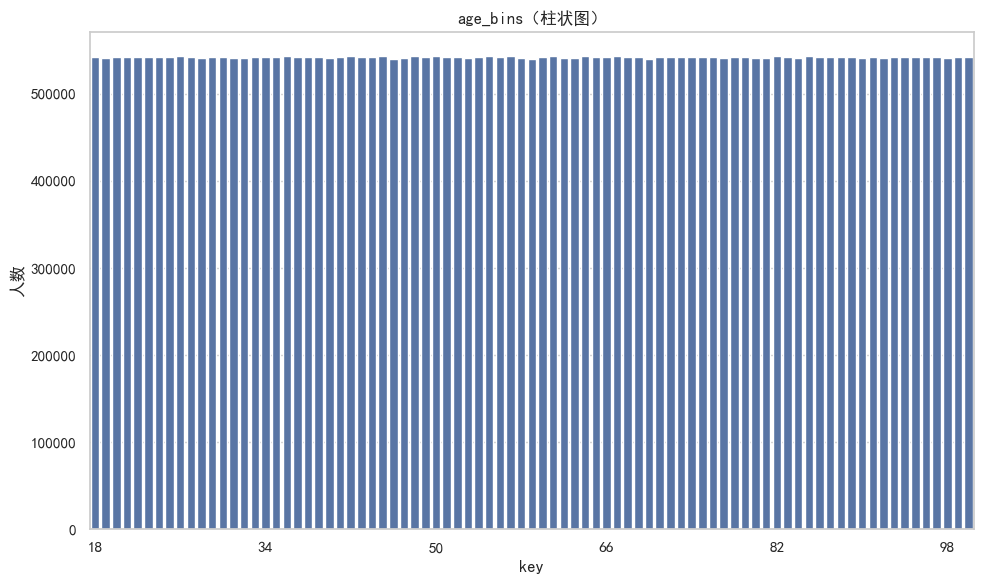

已可视化：age_bins


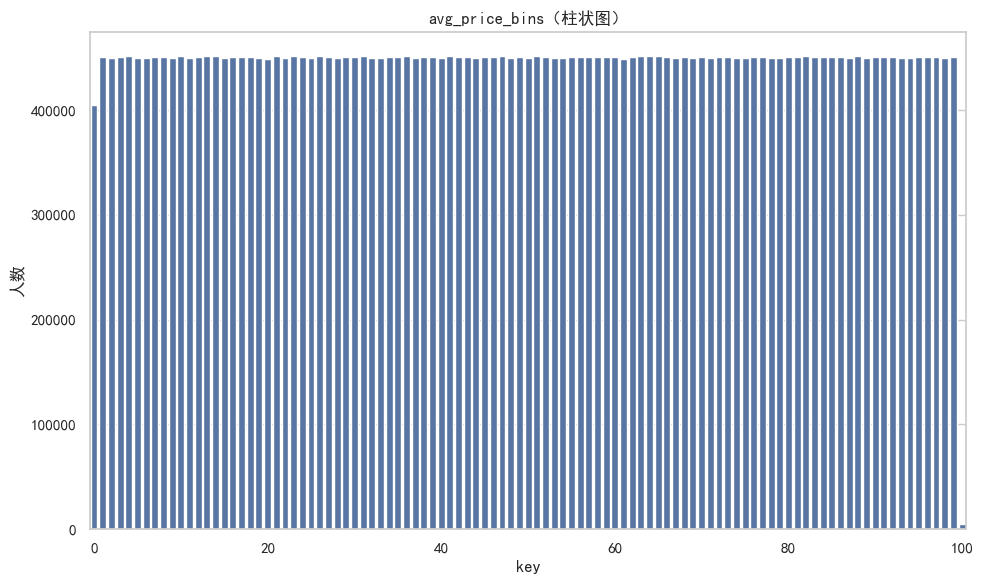

已可视化：avg_price_bins
已可视化：country_bins


<Figure size 1000x600 with 0 Axes>

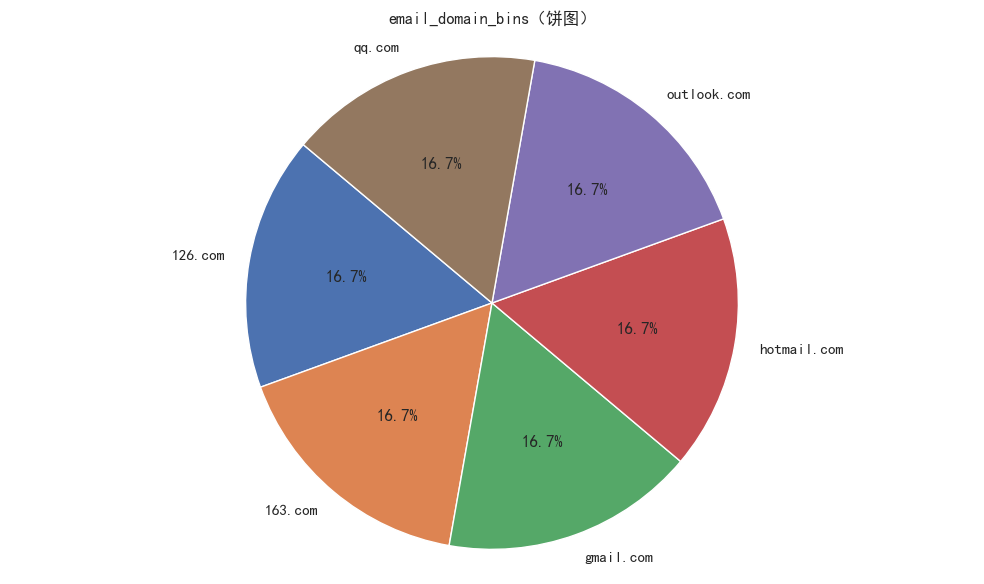

已可视化：email_domain_bins


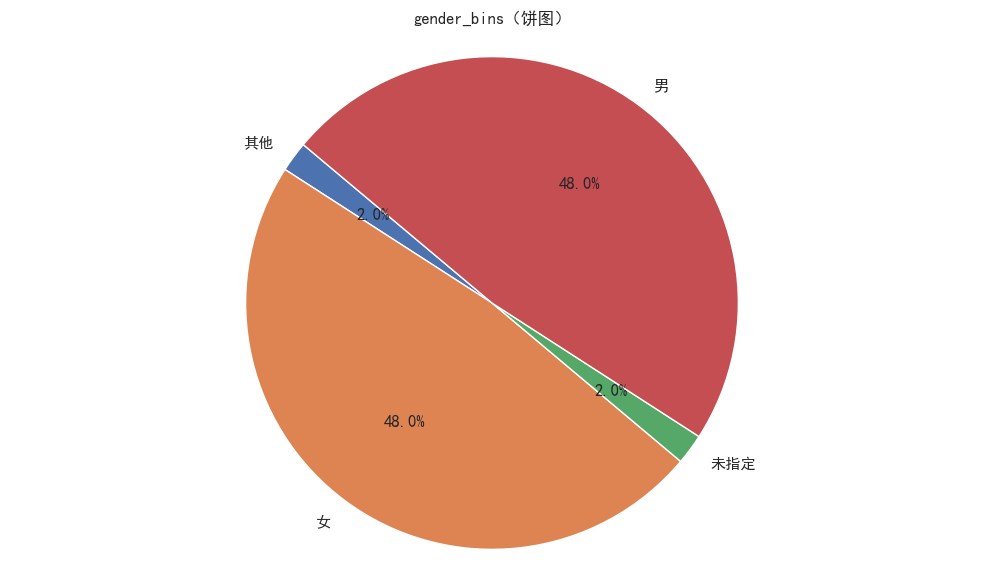

已可视化：gender_bins


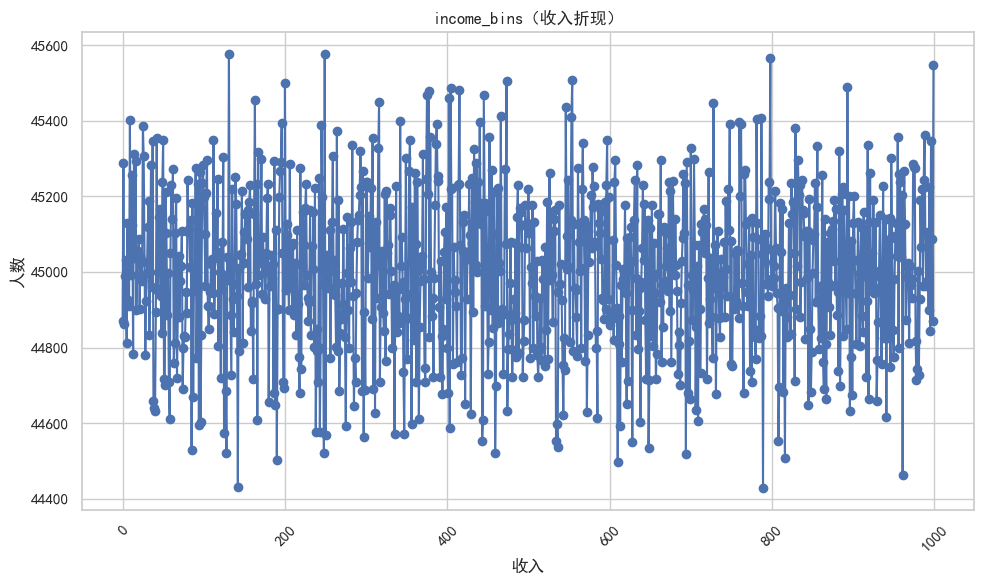

已可视化：income_bins


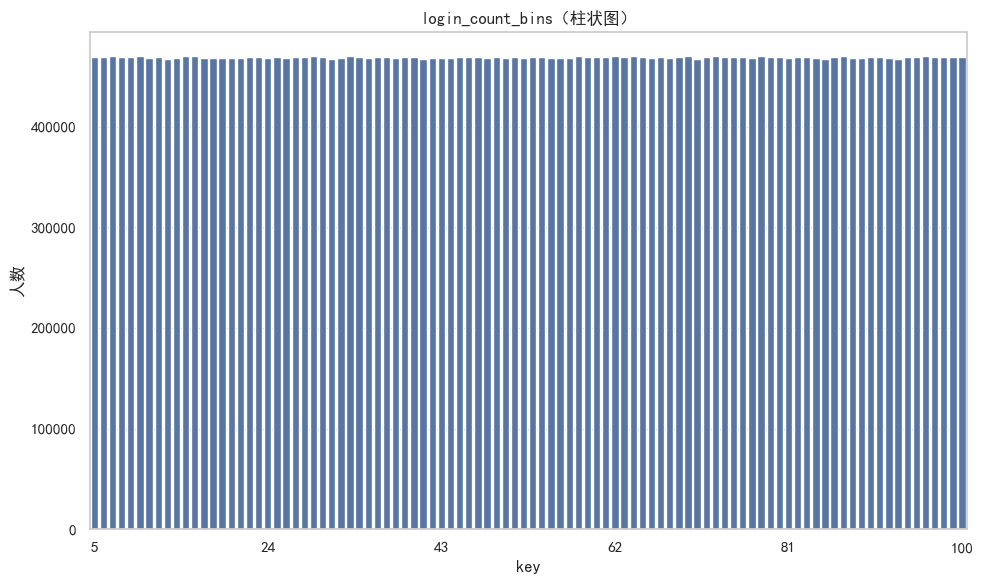

已可视化：login_count_bins


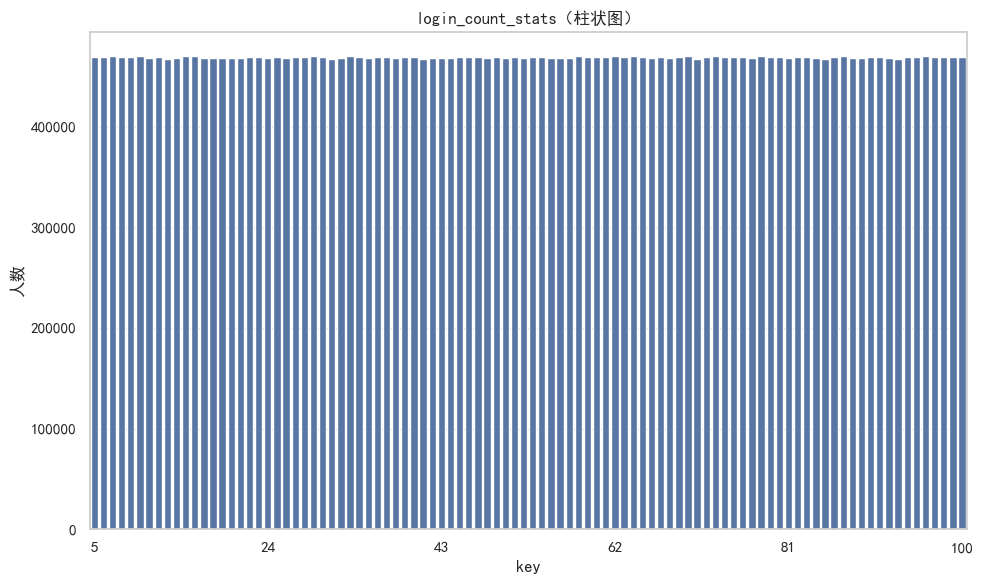

已可视化：login_count_stats


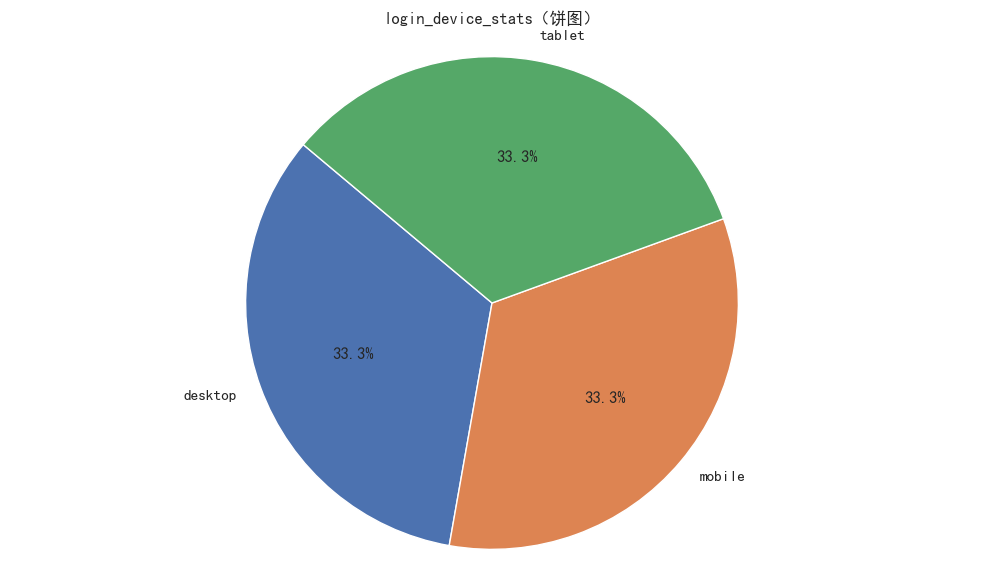

已可视化：login_device_stats


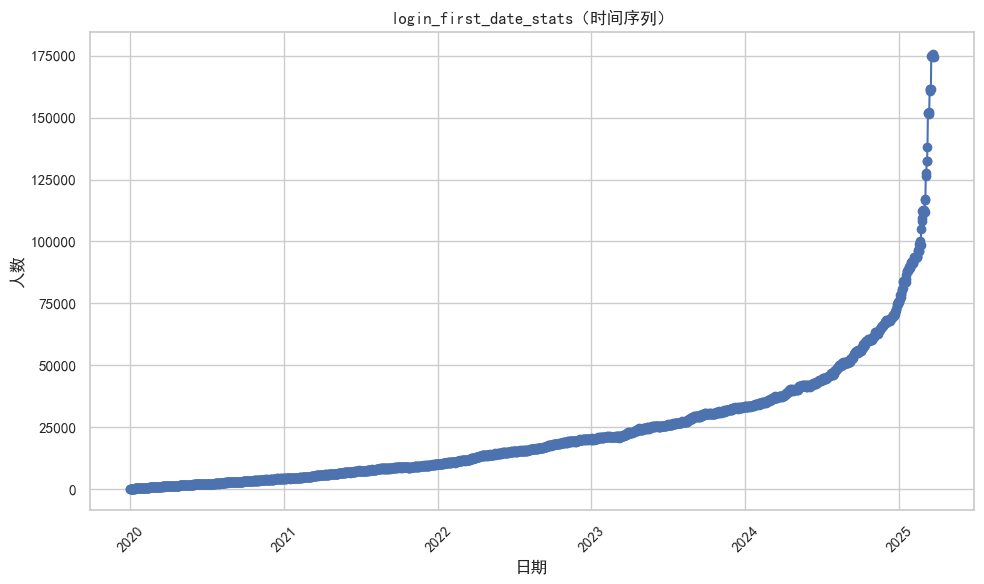

已可视化：login_first_date_stats


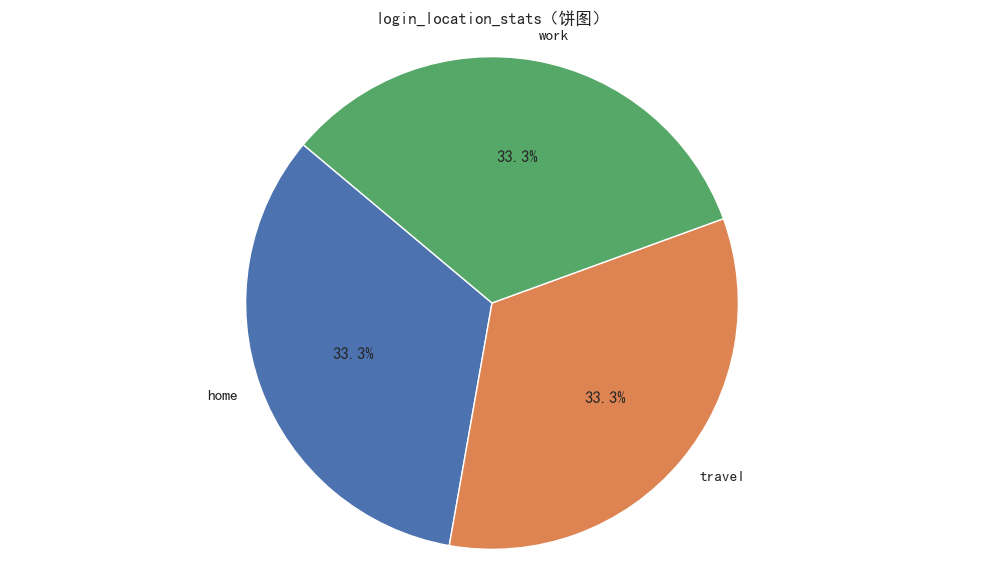

已可视化：login_location_stats


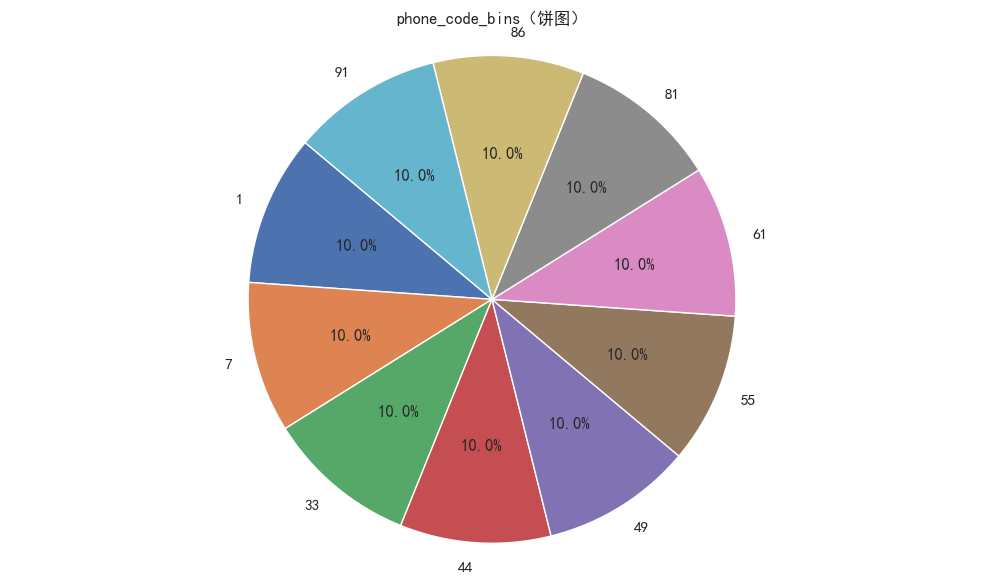

已可视化：phone_code_bins


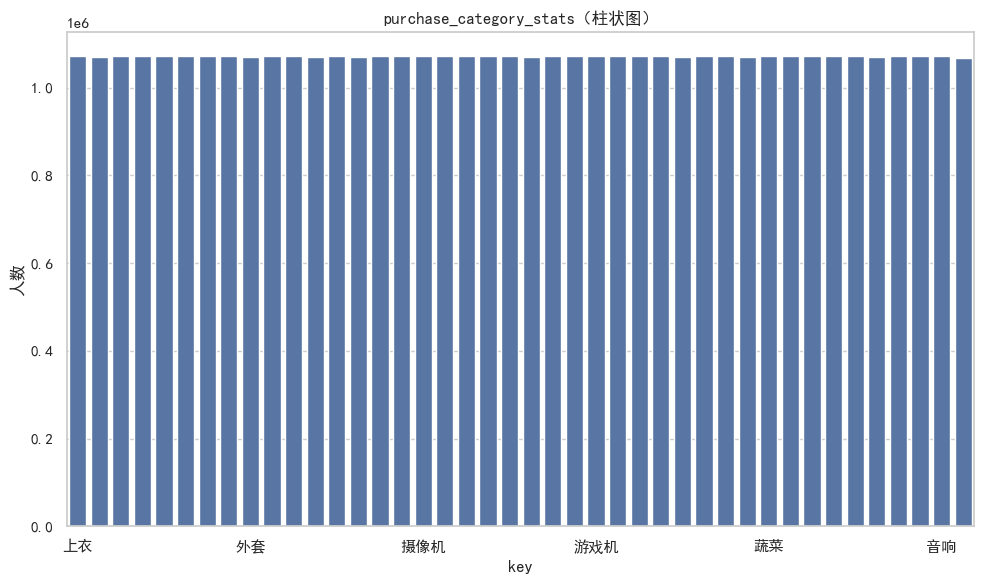

已可视化：purchase_category_stats


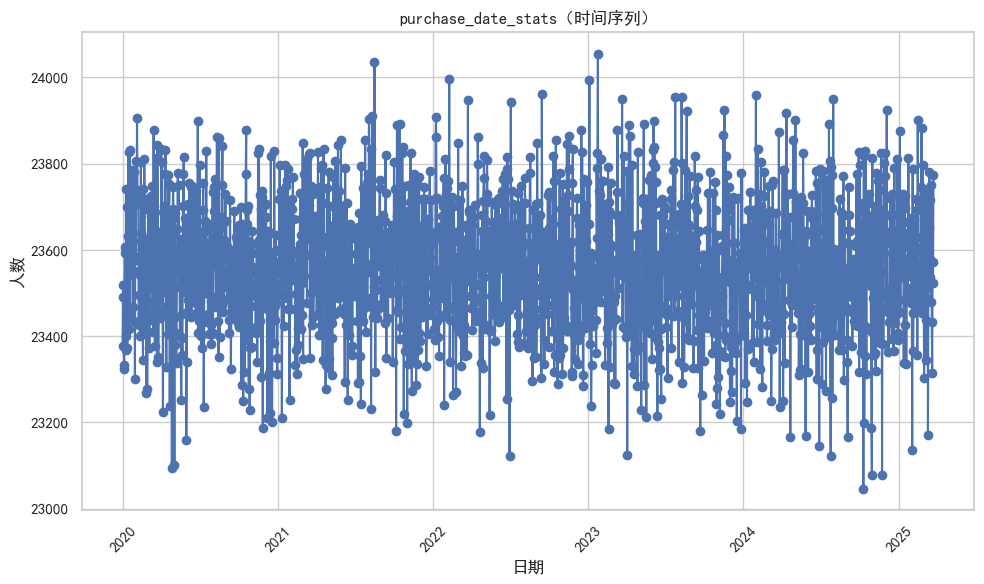

已可视化：purchase_date_stats


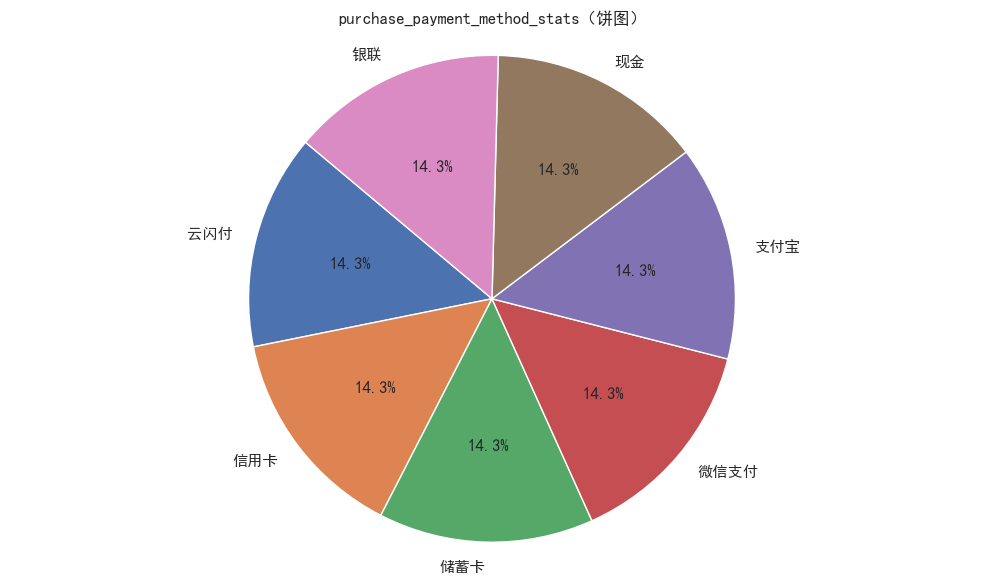

已可视化：purchase_payment_method_stats


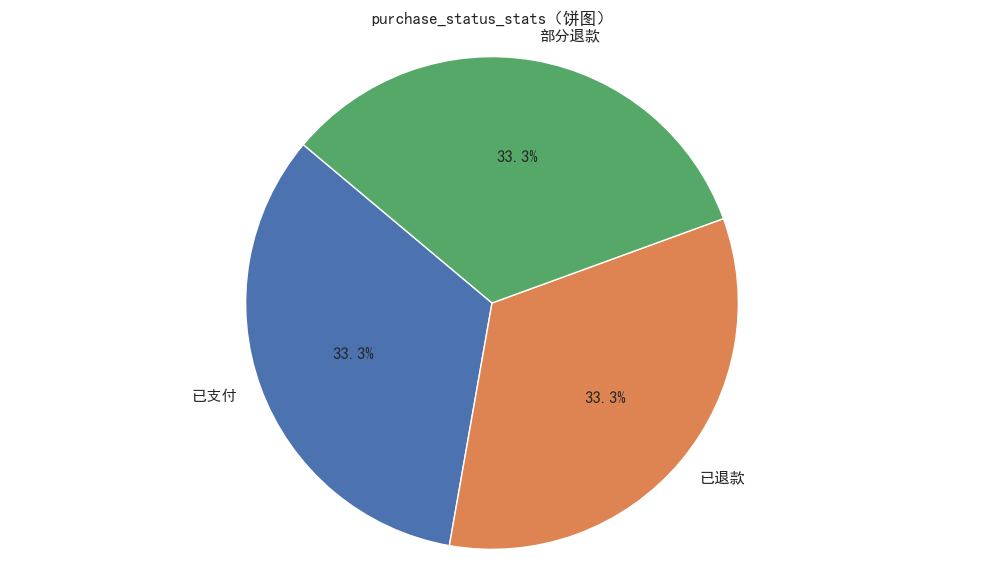

已可视化：purchase_status_stats


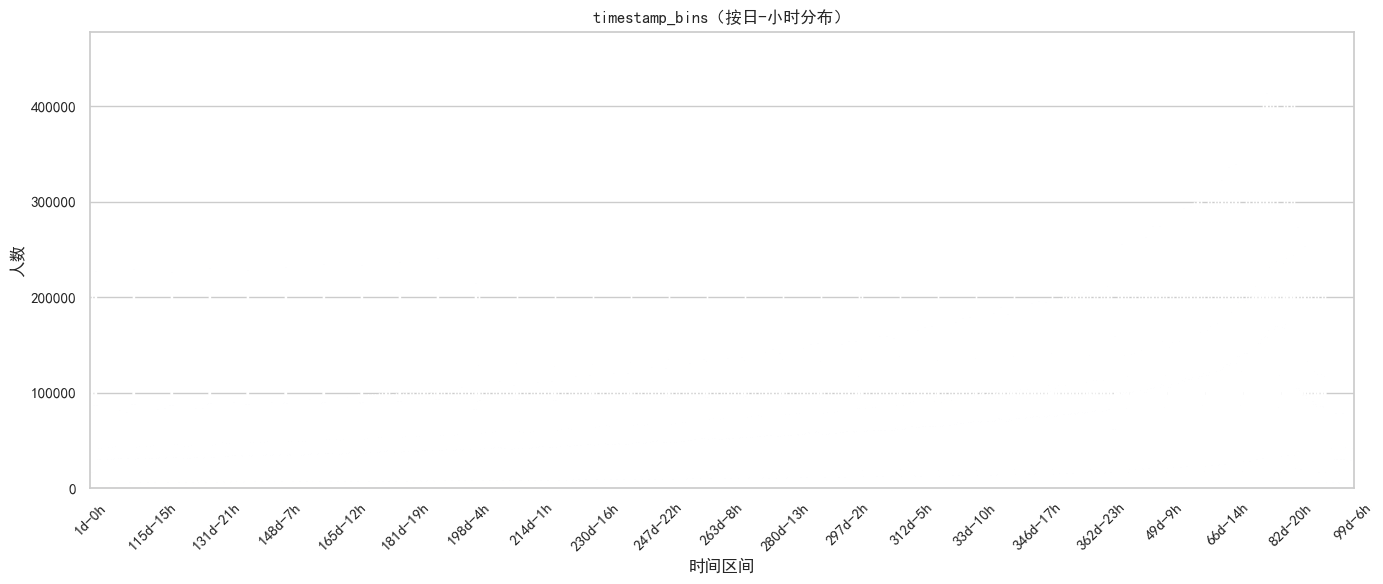

已可视化：timestamp_bins


In [22]:
# 使用函数
visualize_csvs("10G_data_new/sum")


已可视化：address_province_bins


<Figure size 1000x600 with 0 Axes>

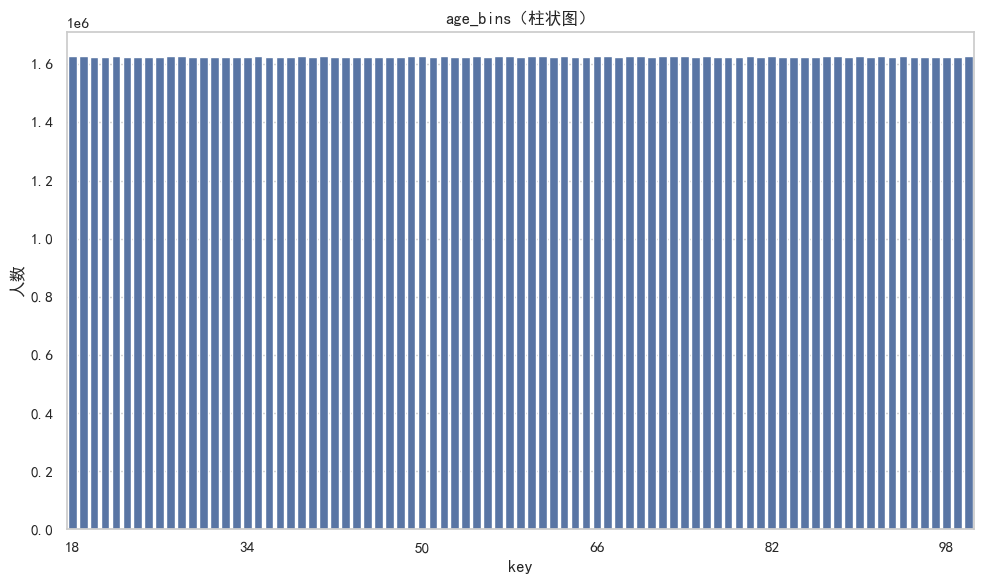

已可视化：age_bins


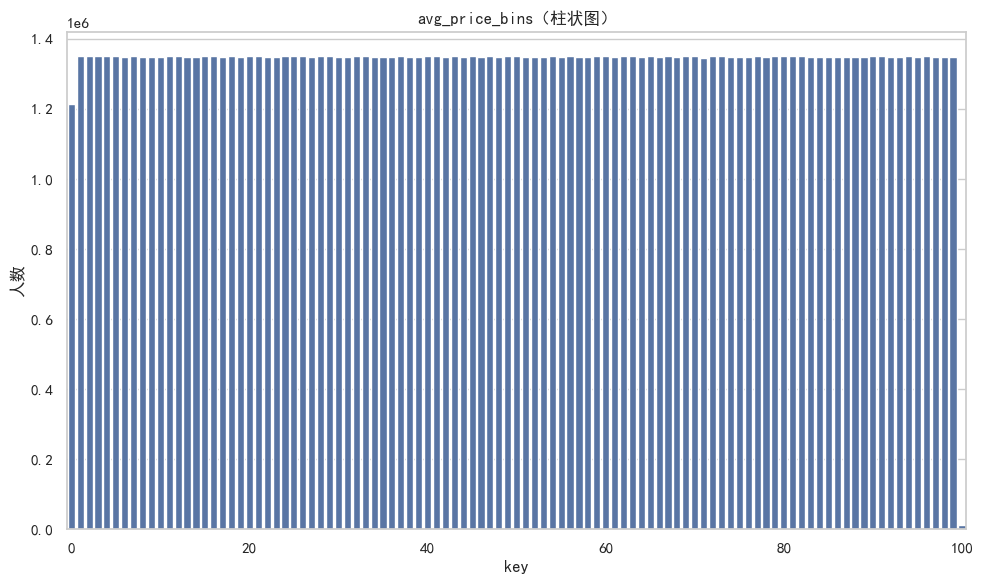

已可视化：avg_price_bins
已可视化：country_bins


<Figure size 1000x600 with 0 Axes>

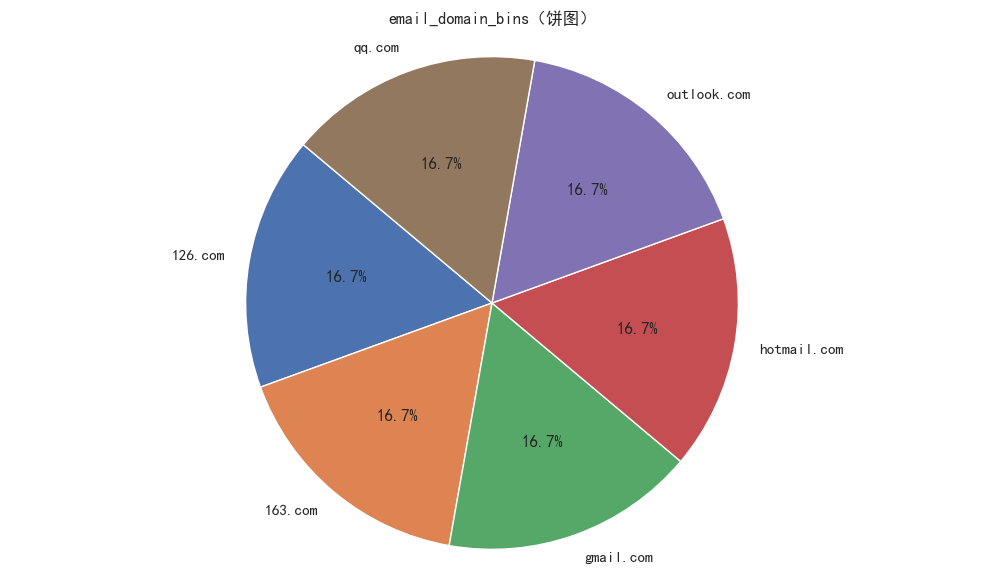

已可视化：email_domain_bins


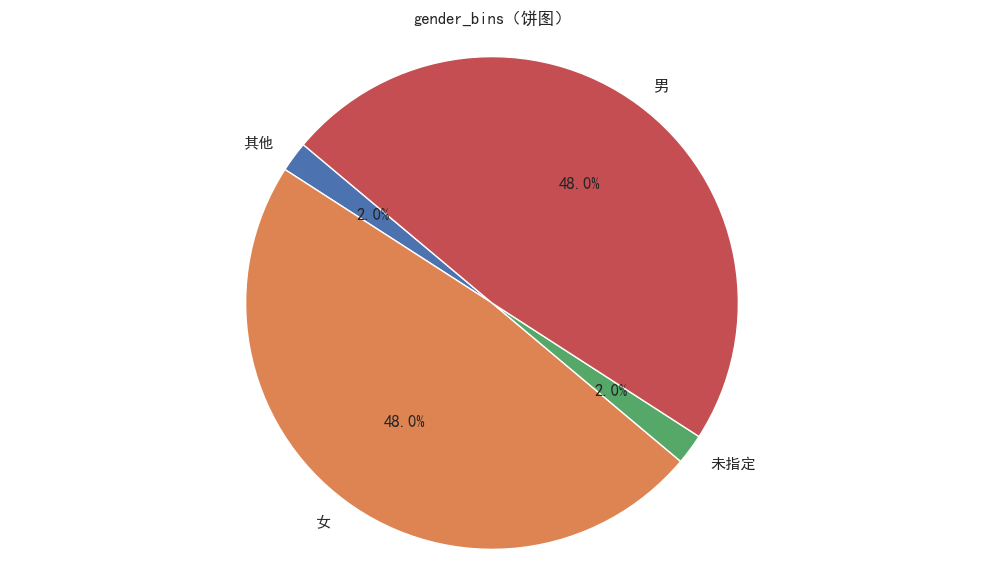

已可视化：gender_bins


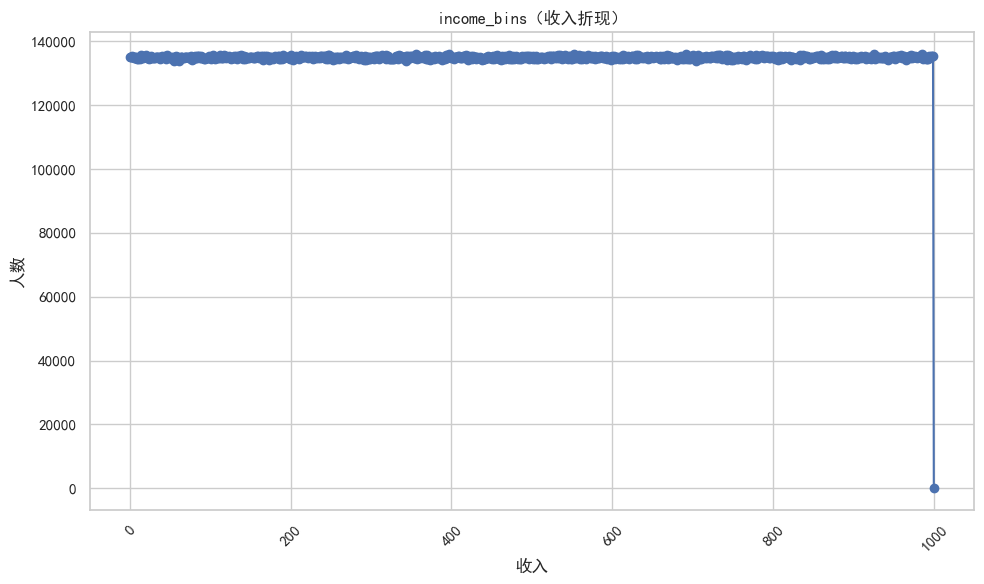

已可视化：income_bins


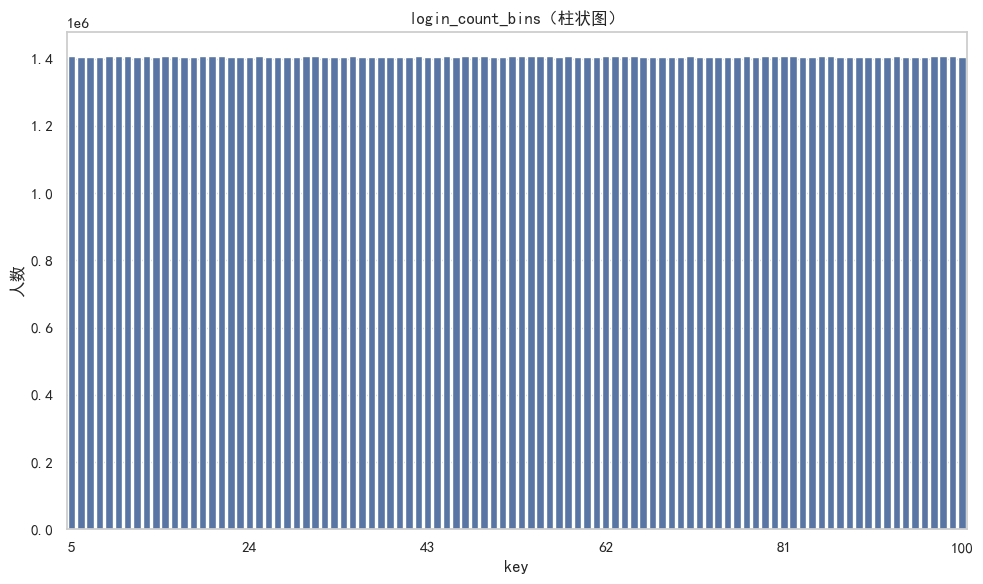

已可视化：login_count_bins


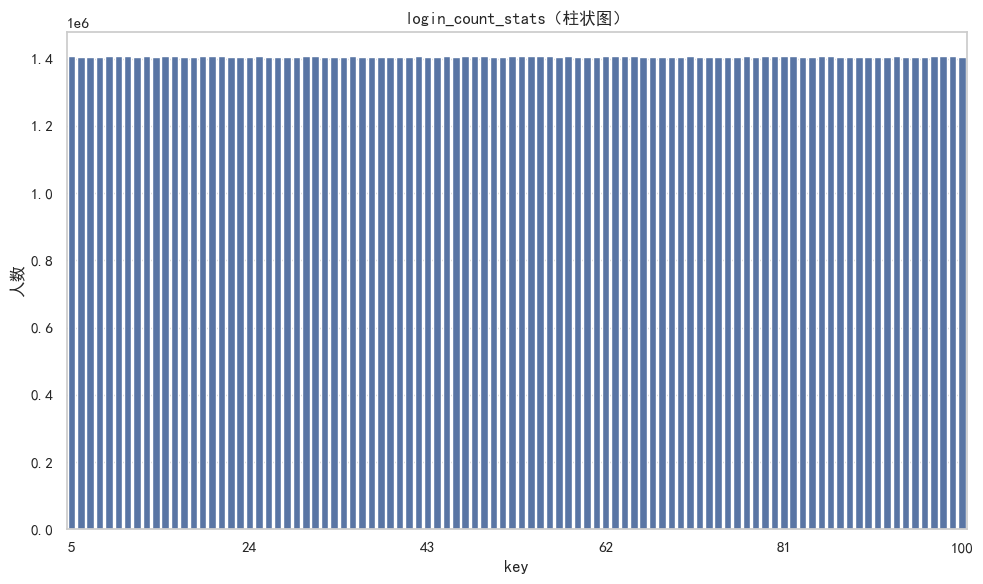

已可视化：login_count_stats


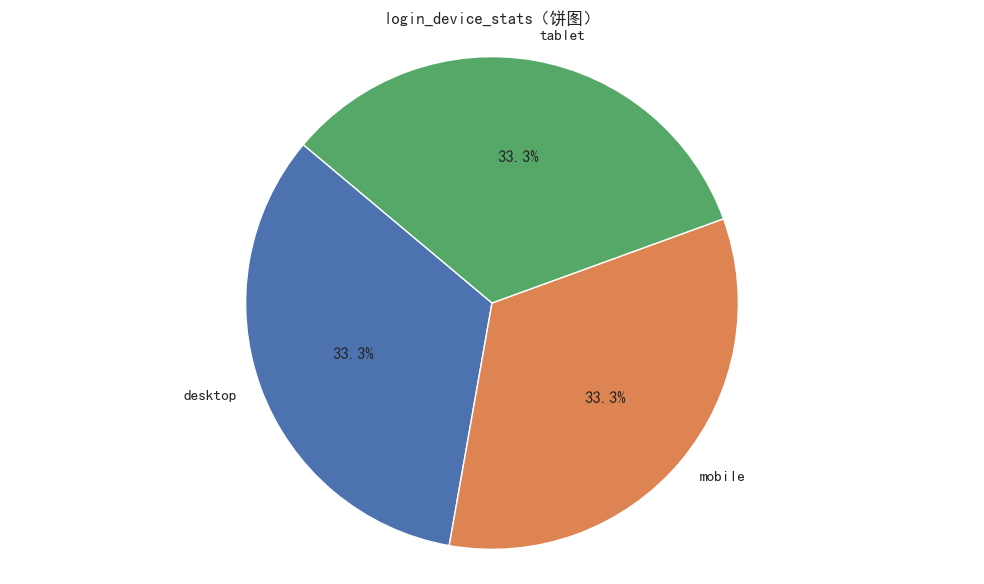

已可视化：login_device_stats


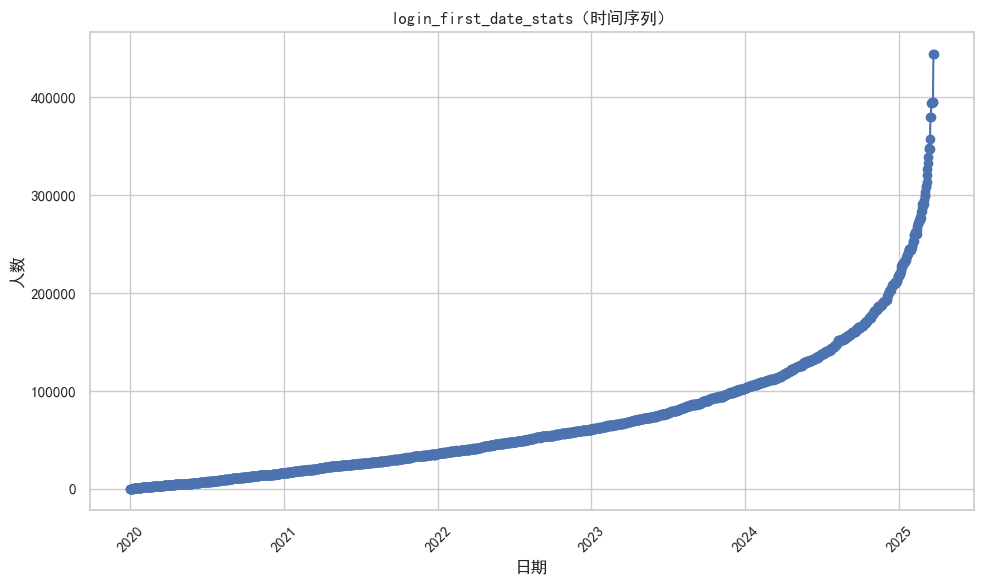

已可视化：login_first_date_stats


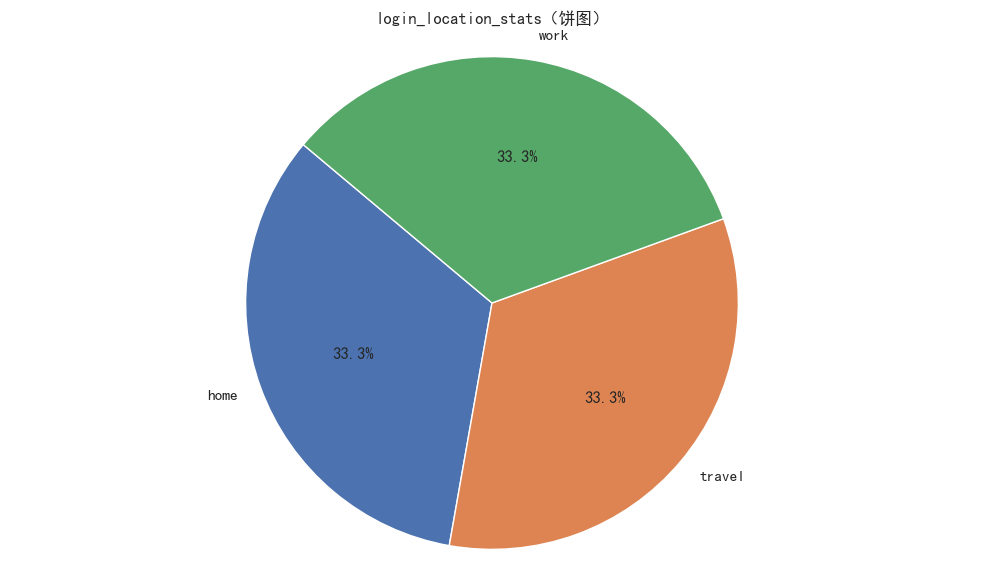

已可视化：login_location_stats


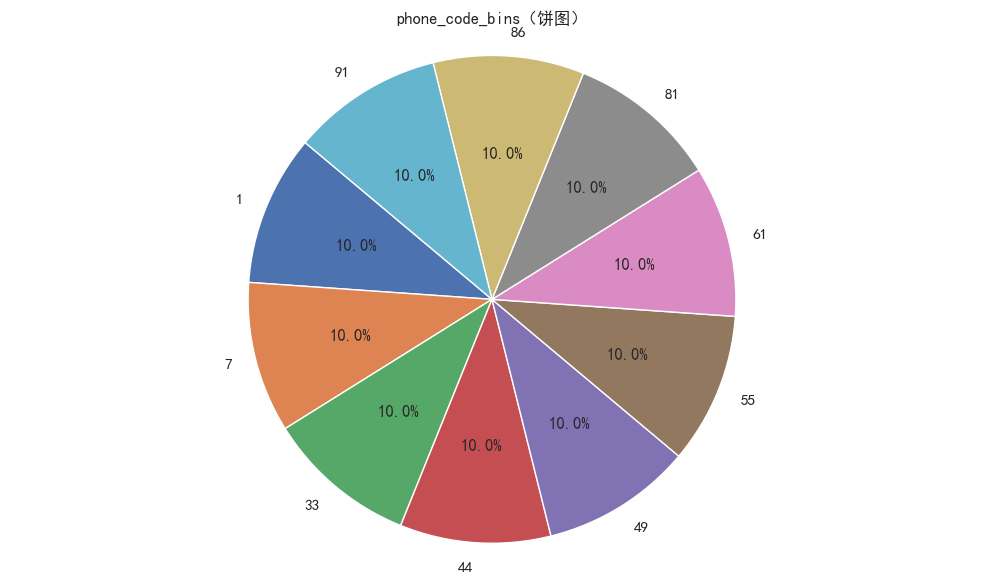

已可视化：phone_code_bins


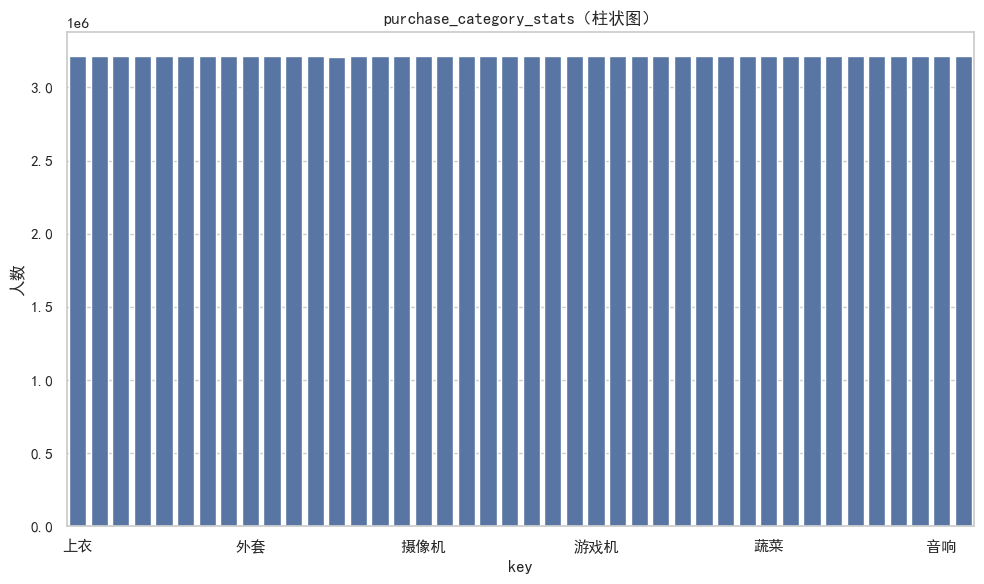

已可视化：purchase_category_stats


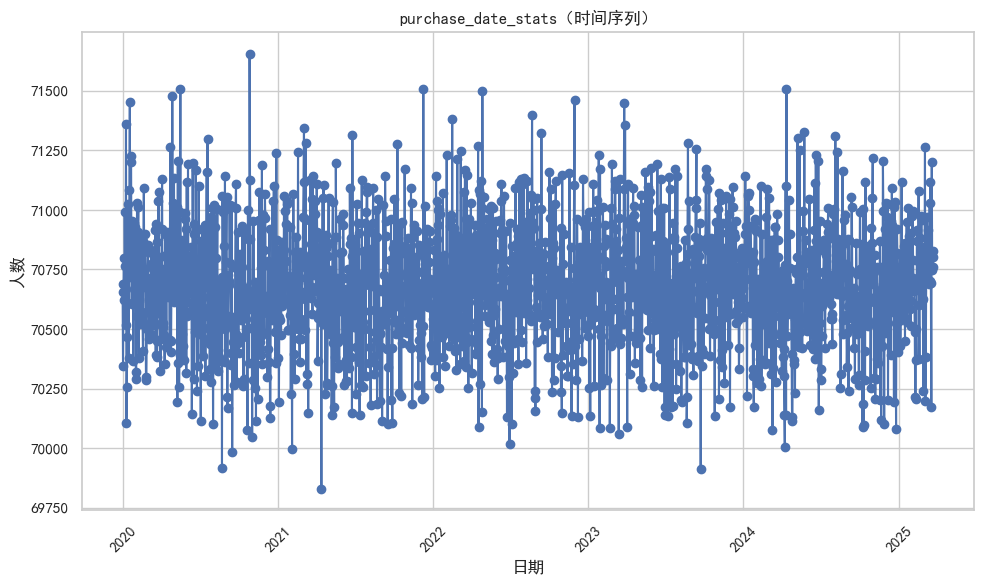

已可视化：purchase_date_stats


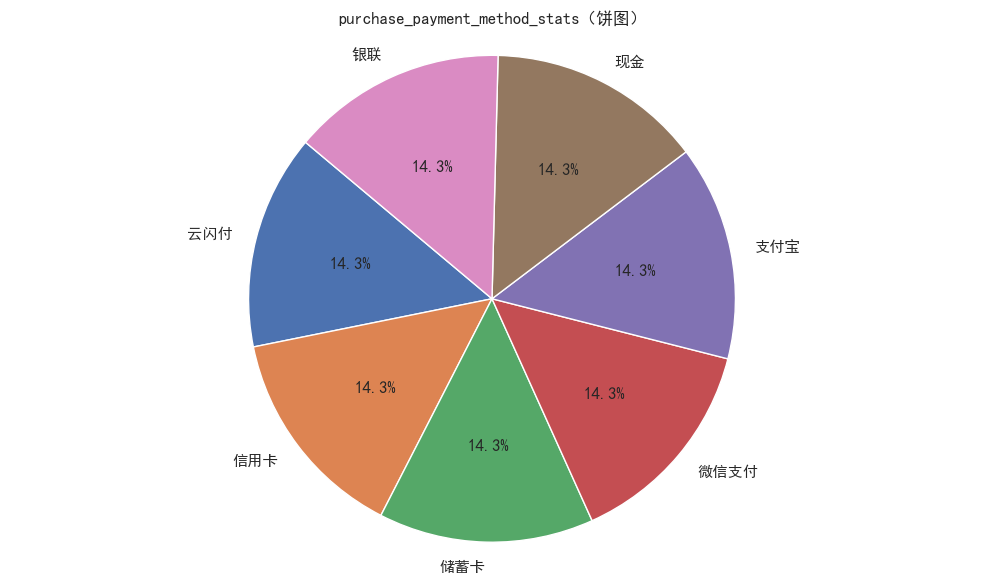

已可视化：purchase_payment_method_stats


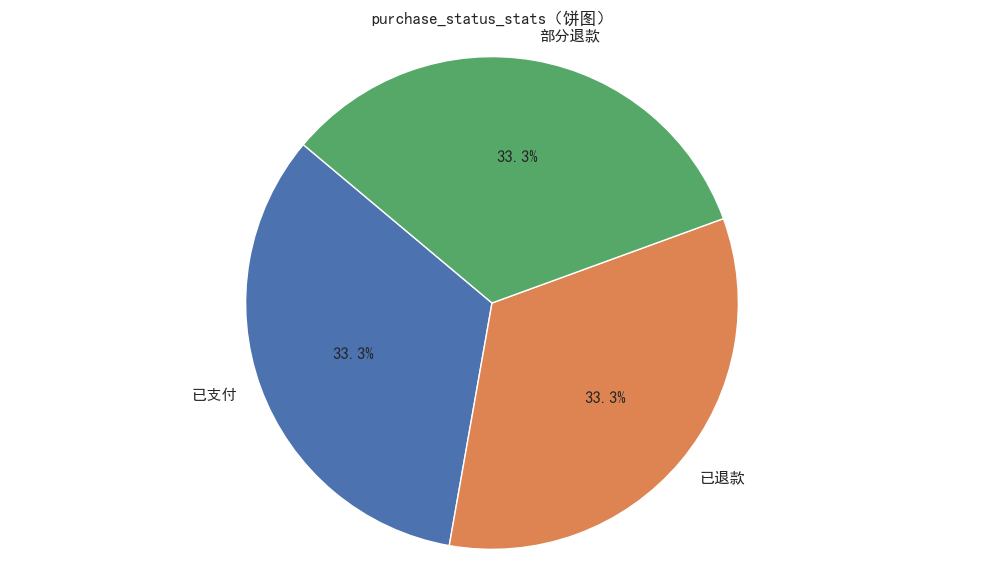

已可视化：purchase_status_stats


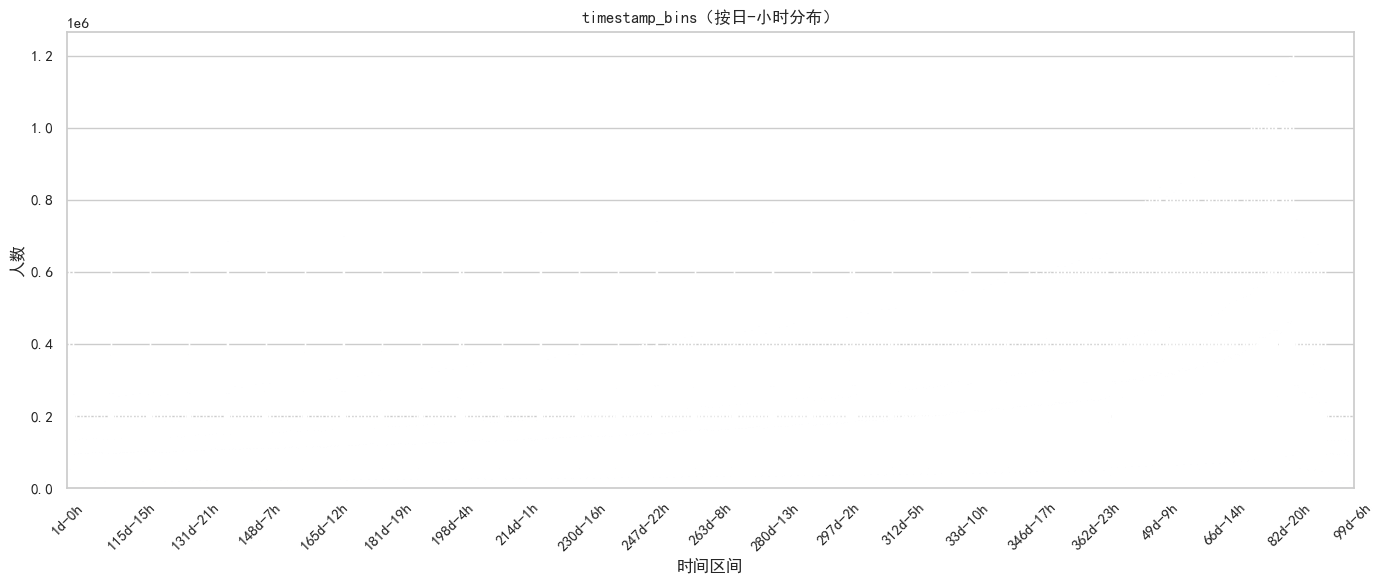

已可视化：timestamp_bins


In [23]:
# 30G
visualize_csvs("30G_data_new/sum")


尽管挪到了windows平台上，甚至用了simhei，还是出现了其他的一些不太美观的状况，具体来说是有些图可能不适合采用柱状图、折线图的方式可视化，分箱太多了，所以还需要进一步的调整

好了，调了很多次，包括柱子数量、展示形式（折现、饼图、柱状）、横坐标（如果太多就间隔书写），总算差不多了

还剩最后一个比较麻烦的，login_history.timestamp的东西

这里我打算重新单独绘图

- 每天的总频次人数（按 day_of_year 统计）
- 每个小时段的总频次人数（按 hour 统计）


In [24]:
def visualize_timestamp_bins(file_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    try:
        df = pd.read_csv(file_path)
        df["key"] = df["key"].apply(eval)

        # 拆分 day 和 hour
        df["day"] = df["key"].apply(lambda x: x[0])
        df["hour"] = df["key"].apply(lambda x: x[1])

        # 1. 每天总频次
        daily_counts = df.groupby("day")["count"].sum().reset_index()

        plt.figure(figsize=(12, 5))
        plt.plot(daily_counts["day"], daily_counts["count"], marker='o')
        plt.title("每天的频次人数（按day_of_year）")
        plt.xlabel("Day of Year")
        plt.ylabel("人数")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "timestamp_daily.png"))
        plt.show()
        plt.close()

        # 2. 每小时段总频次
        hourly_counts = df.groupby("hour")["count"].sum().reset_index()

        plt.figure(figsize=(10, 5))
        sns.barplot(x="hour", y="count", data=hourly_counts)
        plt.title("每小时段的频次人数（0~23h）")
        plt.xlabel("Hour of Day")
        plt.ylabel("人数")
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "timestamp_hourly.png"))
        plt.show()
        plt.close()

        print("timestamp_bins 可视化完成")

    except Exception as e:
        print(f"❌ 处理 timestamp_bins 失败: {e}")


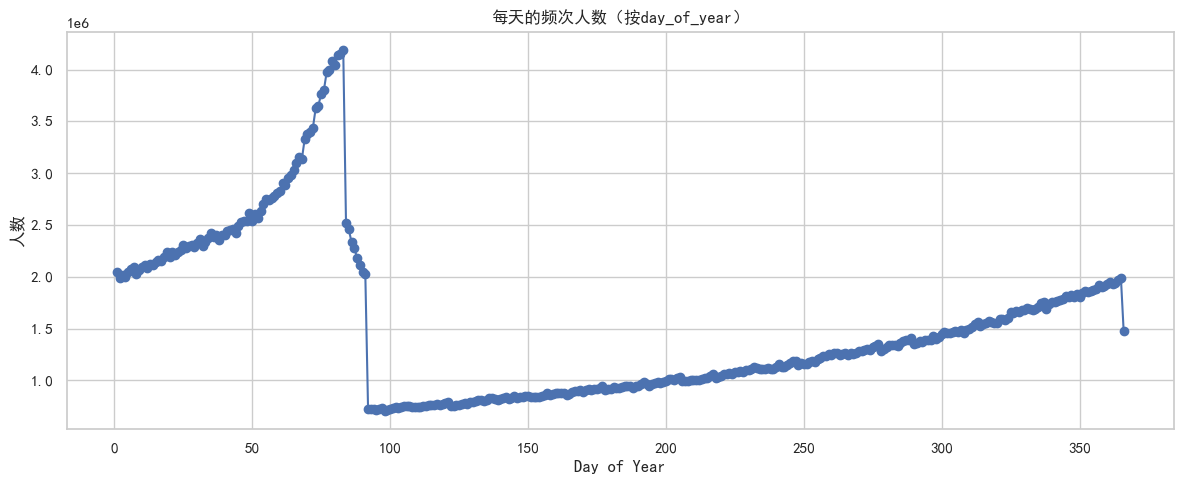

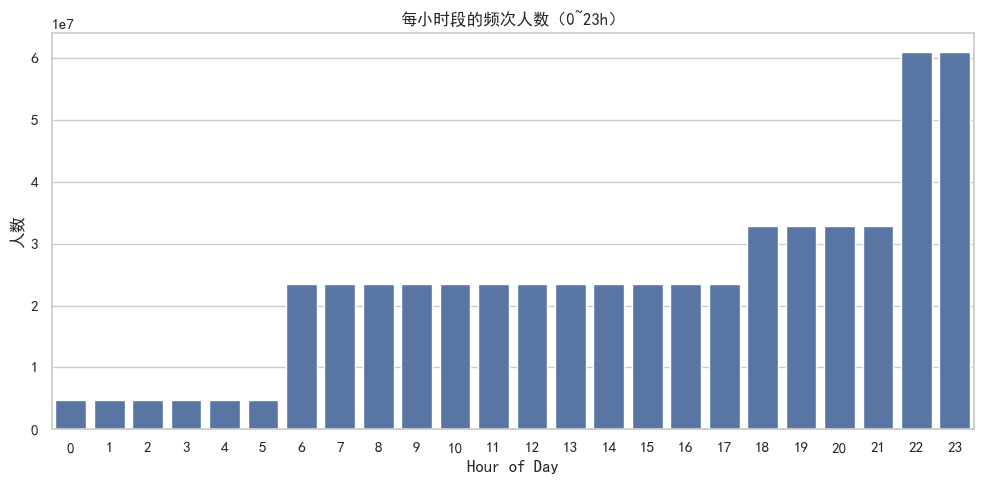

timestamp_bins 可视化完成


In [26]:
visualize_timestamp_bins("10G_data_new/sum/timestamp_bins.csv", "10G_data_new/vis")


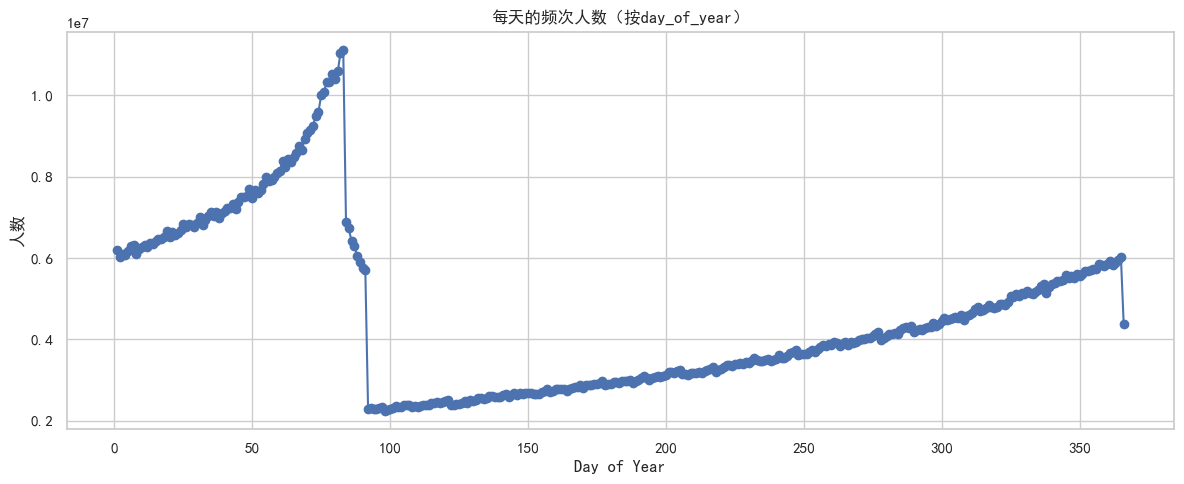

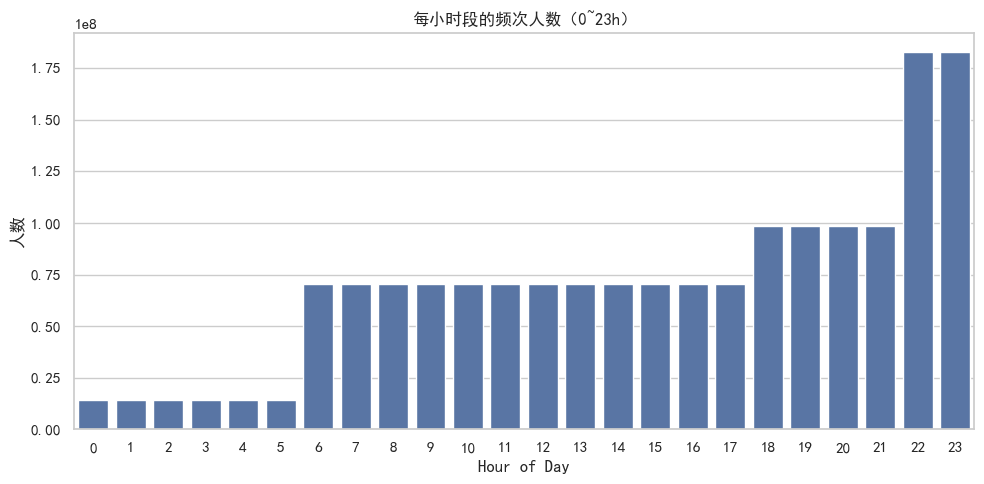

timestamp_bins 可视化完成


In [28]:
visualize_timestamp_bins("30G_data_new/sum/timestamp_bins.csv", "30G_data_new/vis")


可以看出这里终于不是均匀分布了泪目，然后终于有了一些值得挖掘的信息

10G和30G的分布特征一致，大概三月左右会有一个login高峰，以及每天的login高峰在18-24时（尤其是22-24），大家都是夜猫子